# Film Casus

Welkom bij het onderzoek van Team 1! 

- Gemaakt door Yula, Joel en Pim.

## Introduction 

In dit project gaan wij 2 filmdatasets onderzoeken. 

Voor dat we gaan beginnen gaan we eerste nog **data begrijpen** en **data voorbereiden**.

We beantwoorden totaal 3 onderzoeksvragen：
1. In hoeverre is de omzet van een film te voorspellen op basis van de populariteit op Facebook en IMDB？
2. Is het mogelijk om te voorspellen of een film een oscar zal winnen of niet?
3. Hoe kunnen budget en omzet worden gebruikt om logische clusters van de films te vinden?

## Data Understanding

**Alle imports**

In [1]:
import functies as fn
import pandas as pd
from IPython.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
from sklearn.metrics import r2_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as lm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import graphviz
from sklearn.mixture import GaussianMixture as gmm
from sklearn.cluster import KMeans

**Laad de dataset**

In [2]:
dfr = pd.read_csv('data/movie-1.csv')

# Toon de maximale informatie die de dataframe kan geven.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Formatteer alle grote getallen voor een betere leesbaarheid.
pd.set_option('display.float_format', '{:,.2f}'.format)

**Kopie van de dataset**


Een kopie van de gegevens maken om mee te werken,
zodat we het oorspronkelijke dataset niet wijzigen.

In [3]:
df = dfr.copy()

**Een kijkje nemen naar de gegevens die we hebben gekregen.**

In [4]:
df.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.00,178.00,0.00,855.00,Joel David Moore,"1,000.00","760,505,847.00",Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.00,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,"3,054.00",English,USA,PG-13,"237,000,000.00","2,009.00",936.00,7.90,1.78,33000
1,Color,Gore Verbinski,302.00,169.00,563.00,"1,000.00",Orlando Bloom,"40,000.00","309,404,152.00",Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.00,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,"1,238.00",English,USA,PG-13,"300,000,000.00","2,007.00","5,000.00",7.10,2.35,0
2,Color,Sam Mendes,602.00,148.00,0.00,161.00,Rory Kinnear,"11,000.00","200,074,175.00",Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.00,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.00,English,UK,PG-13,"245,000,000.00","2,015.00",393.00,6.80,2.35,85000
3,Color,Christopher Nolan,813.00,164.00,"22,000.00","23,000.00",Christian Bale,"27,000.00","448,130,642.00",Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.00,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,"2,701.00",English,USA,PG-13,"250,000,000.00","2,012.00","23,000.00",8.50,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.00,NaN,Rob Walker,131.00,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.00,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.00,7.10,NaN,0


**Haal de kolomnamen op om te zien met wat voor soort variabelen we werken**

In [5]:
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

## Meetniveaus

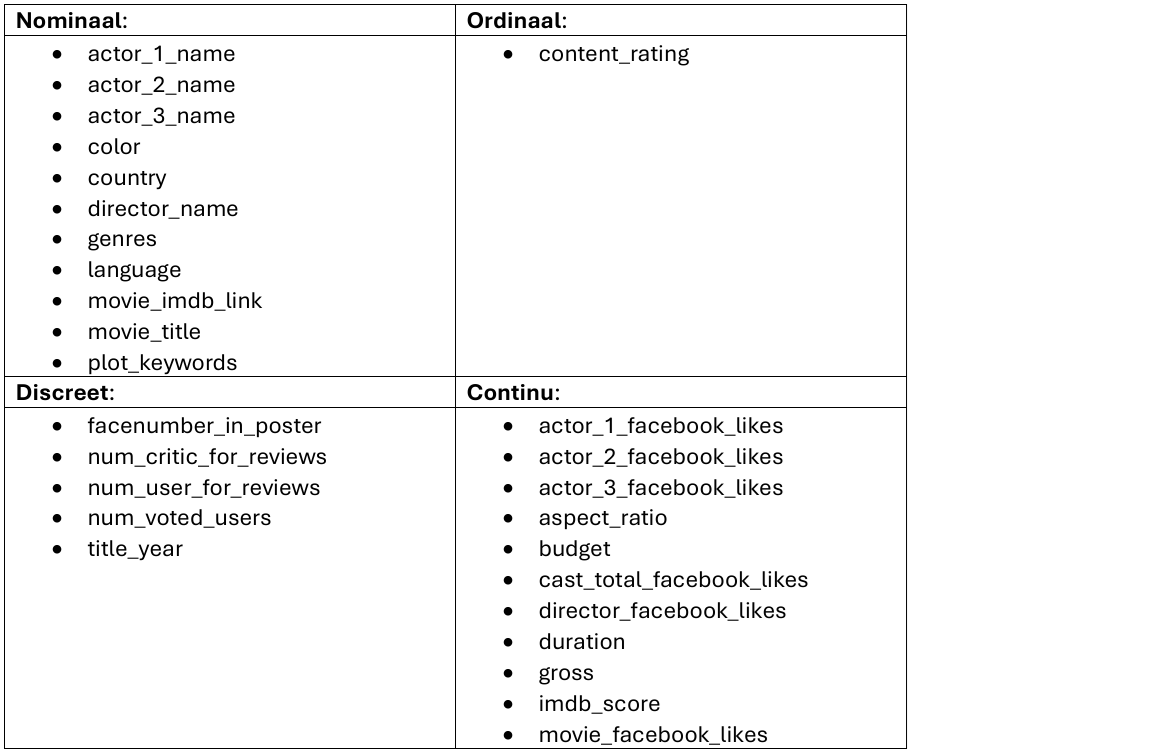

In [6]:
display(Image(filename="meetniveaus.png"))

## Data Preparation

**Doel- en kenmerkenvariabelen**


De target variabel is al gegeven, namelijk de 'gross' kolom.
De gross is afhankelijk van de feature variables, die zijn onafhankelijk.
We hebben gekozen voor deze feature variabelen omdat deze kolommen het best passen bij onze onderzoeksvraag. We moeten het voorspellen aan de hand van de populariteit van facebook en IMDB. Ofwel de statistieken van deze 2.

In [7]:
featureVariables = ['director_facebook_likes', 
                    'actor_1_facebook_likes', 
                    'actor_2_facebook_likes', 
                    'actor_3_facebook_likes', 
                    'cast_total_facebook_likes', 
                    'movie_facebook_likes', 
                    'imdb_score']

targetVariable = ['gross']

**Maak een andere dataframe met alleen de kolommen waarin we geïnteresseerd zijn.**

Door alleen deze te nemen, gaat onze dataset van 28 naar 8 kolommen.

In [8]:
print(df.shape) #check impact
df = df[featureVariables + targetVariable]
print(df.shape) #check impact

(5043, 28)
(5043, 8)


**Controleer NaN-waarden**

Verwijder voorlopig alle NaN-waarden in de kenmerken- en doelvariabelen. Later zullen we verder onderzoeken hoe we deze op de juiste manier kunnen verwerken.

In [9]:
df.isna().sum()

director_facebook_likes      104
actor_1_facebook_likes         7
actor_2_facebook_likes        13
actor_3_facebook_likes        23
cast_total_facebook_likes      0
movie_facebook_likes           0
imdb_score                     0
gross                        884
dtype: int64

We zullen alle NaN-waarden verwijderen. We kunnen ze niet vervangen, omdat de meerderheid onze doelvariabele bevat.

In [10]:
print(df.shape) #check impact
df = df.dropna()
print(df.shape) #check impact

(5043, 8)
(4143, 8)


**Nu zullen we alle kolommen analyseren om te controleren op anomalieën.**

Alle statistieken zien er schoon uit.

Alle kolommen met 'namen' bevatten NaN en getallen waar dit verwacht wordt.

Alle kolommen met 'likes' bevatten NaN en een getal waar dit verwacht wordt. Ook geen vreemde minimale of maximale waarden.

De kolom 'imdb_score' heeft alleen waarden tussen 0 en 10, wat verwacht wordt.

En tot slot heeft de kolom 'gross' een natuurlijke orde van grootte van min tot max.

In [11]:
df.describe(include="all")

,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,movie_facebook_likes,imdb_score,gross
count,"4,143.00","4,143.00","4,143.00","4,143.00","4,143.00","4,143.00","4,143.00","4,143.00"
mean,749.23,"7,361.56","1,892.58",724.28,"10,920.21","8,757.63",6.47,"48,625,081.48"
std,"2,950.71","15,067.61","4,374.79","1,811.38","18,541.78","20,822.02",1.05,"68,528,637.84"
min,0.00,0.00,0.00,0.00,0.00,0.00,1.60,162.00
25%,10.00,702.00,345.00,173.00,"1,755.50",0.00,5.90,"5,404,758.50"
50%,57.00,"1,000.00",651.00,416.00,"3,715.00",186.00,6.60,"25,592,632.00"
75%,218.50,"12,000.00",962.00,676.00,"15,601.50","10,000.00",7.20,"62,427,289.50"
max,"23,000.00","640,000.00","137,000.00","23,000.00","656,730.00","349,000.00",9.30,"760,505,847.00"


### Beschrijving variables

#### director_facebook_likes (Facebook likes voor de regisseur):  
Aantal waarden: 4143  
Gemiddelde: 749,23 likes  
Standaarddeviatie: 2950,71 likes (grote variatie in likes)  
Minimum: 0 likes  
25e percentiel: 10 likes  
Mediaan: 57 likes  
75e percentiel: 218,5 likes  
Maximum: 23.000 likes  

#### actor_1_facebook_likes (Facebook likes voor de hoofdacteur):  
Aantal waarden: 4143  
Gemiddelde: 7.361,56 likes  
Standaarddeviatie: 15.067,61 likes  
Minimum: 0 likes  
25e percentiel: 702 likes  
Mediaan: 1.000 likes  
75e percentiel: 12.000 likes  
Maximum: 640.000 likes  

#### actor_2_facebook_likes (Facebook likes voor de tweede acteur):  
Aantal waarden: 4143  
Gemiddelde: 1.892,58 likes  
Standaarddeviatie: 4.374,79 likes  
Minimum: 0 likes  
25e percentiel: 345 likes  
Mediaan: 651 likes  
75e percentiel: 962 likes  
Maximum: 137.000 likes  

#### actor_3_facebook_likes (Facebook likes voor de derde acteur):  
Aantal waarden: 4143  
Gemiddelde: 724,28 likes  
Standaarddeviatie: 1.811,38 likes  
Minimum: 0 likes  
25e percentiel: 173 likes  
Mediaan: 416 likes  
75e percentiel: 676 likes  
Maximum: 23.000 likes  

#### cast_total_facebook_likes (Totaal aantal Facebook likes voor de cast):  
Aantal waarden: 4143  
Gemiddelde: 10.920,21 likes  
Standaarddeviatie: 18.541,78 likes  
Minimum: 0 likes  
25e percentiel: 1.755,5 likes  
Mediaan: 3.715 likes  
75e percentiel: 15.601,5 likes  
Maximum: 656.730 likes  

#### movie_facebook_likes (Facebook likes voor de film):  
Aantal waarden: 4143  
Gemiddelde: 8.757,63 likes  
Standaarddeviatie: 20.822,02 likes  
Minimum: 0 likes  
25e percentiel: 0 likes  
Mediaan: 186 likes  
75e percentiel: 10.000 likes  
Maximum: 349.000 likes  

#### imdb_score (IMDb score):  
Aantal waarden: 4143  
Gemiddelde: 6,47  
Standaarddeviatie: 1,05  
Minimum: 1,6  
25e percentiel: 5,9  
Mediaan: 6,6  
75e percentiel: 7,2  
Maximum: 9,3  

#### gross (Bruto-opbrengst):  
Aantal waarden: 4143  
Gemiddelde: 48,63 miljoen USD  
Standaarddeviatie: 68,53 miljoen USD  
Minimum: 162 USD  
25e percentiel: 5,40 miljoen USD  
Mediaan: 25,59 miljoen USD  
75e percentiel: 62,43 miljoen USD  
Maximum: 760,51 miljoen USD  
oen USD
Minimum: 162 USD
25e percentiel: 5,34 miljoen USD
Mediaan: 25,52 miljoen USD
75e percentiel: 62,31 miljoen USD
Maximum: 760,51 miljoen USD

### Boxplots en uitschieters
We zullen geen van de uitschieters uit onze doelvariabele 'gross' verwijderen. Voor onze kenmerkenvariabelen zijn er echter enkele vreemde uitschieters en veel regisseurs en acteurs met 0 likes op Facebook. 

Er is super veel variatie tussen alle feature variabelen. Wij verwachten dat films met een hoge like score op alle gebieden, hoger zal scoren in hun omzet.

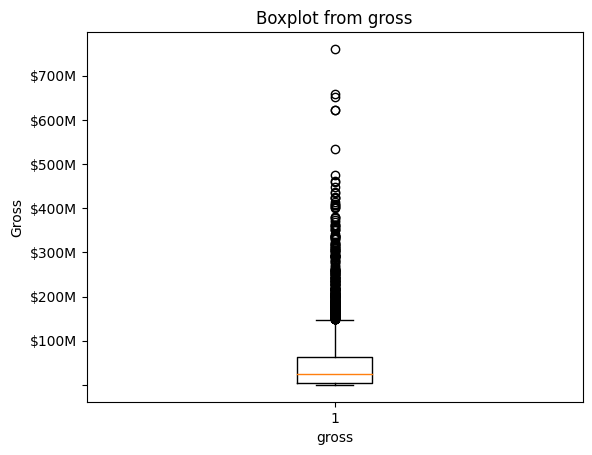

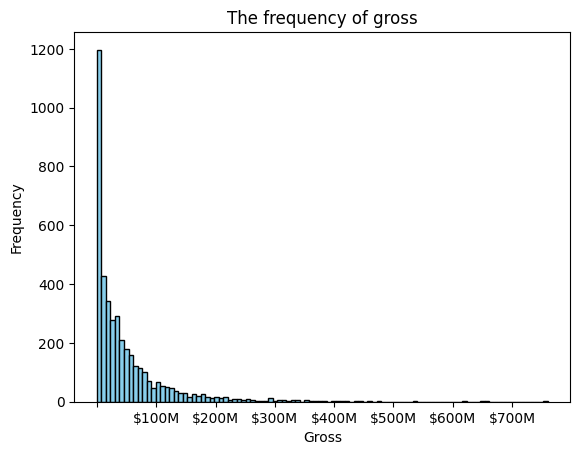

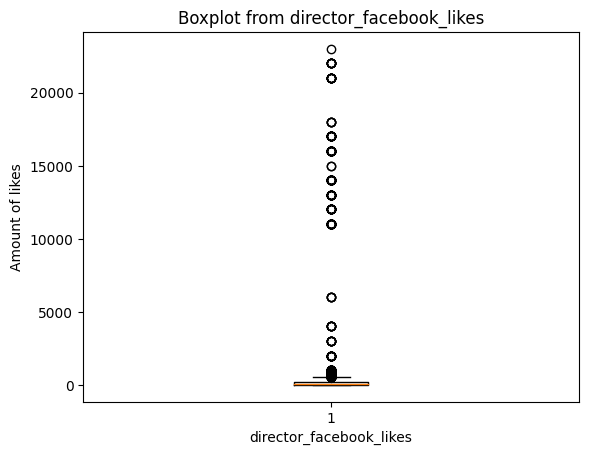

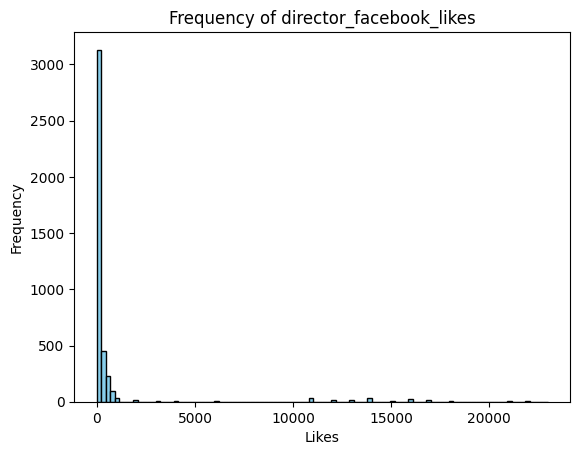

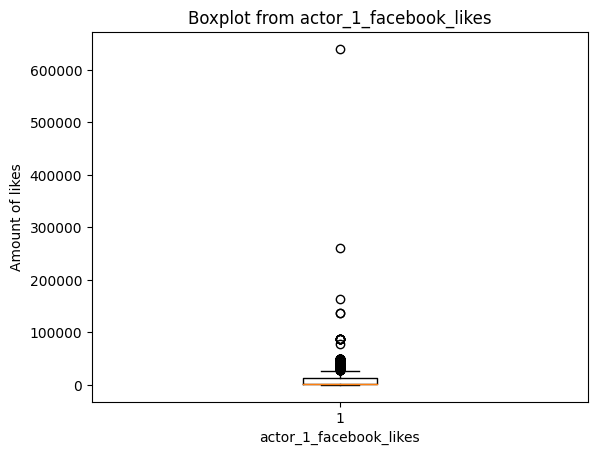

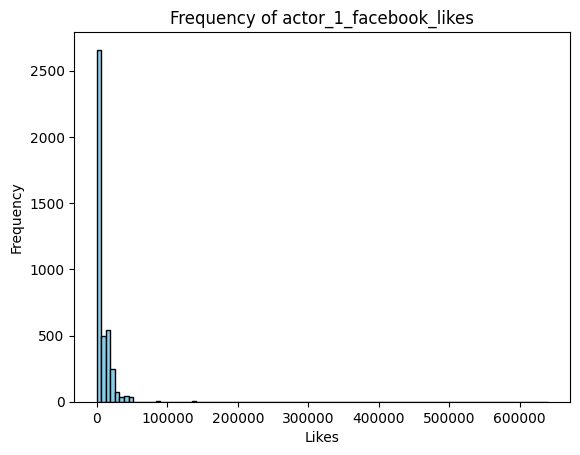

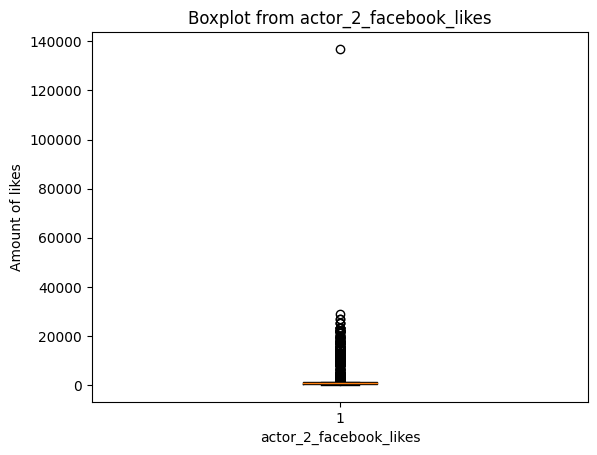

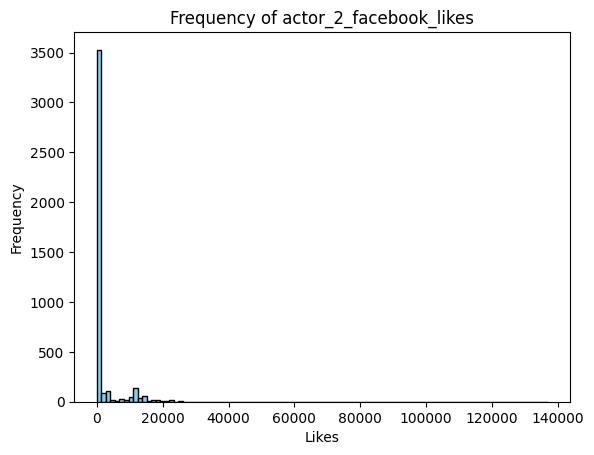

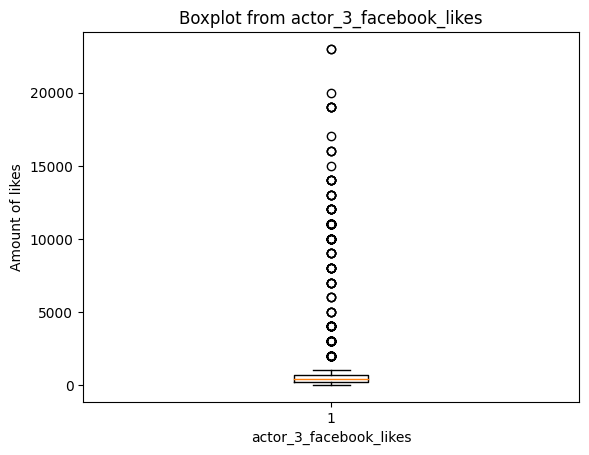

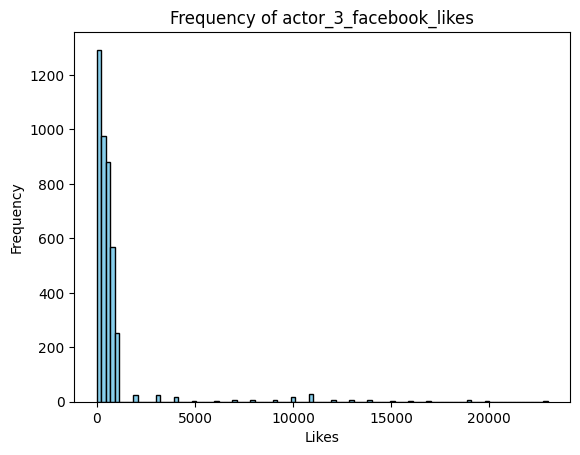

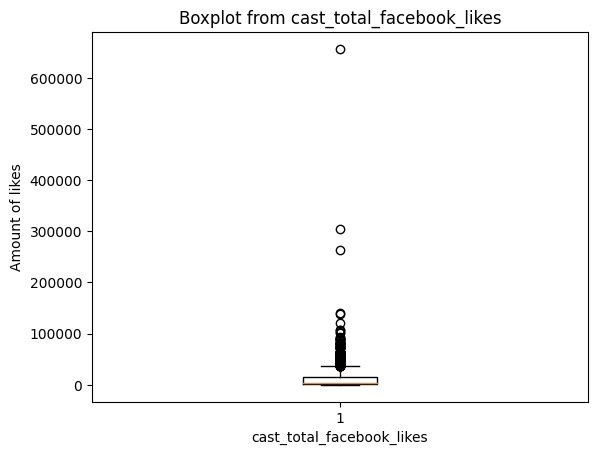

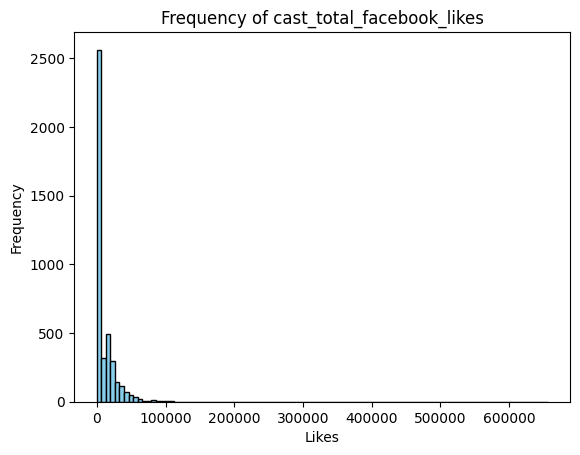

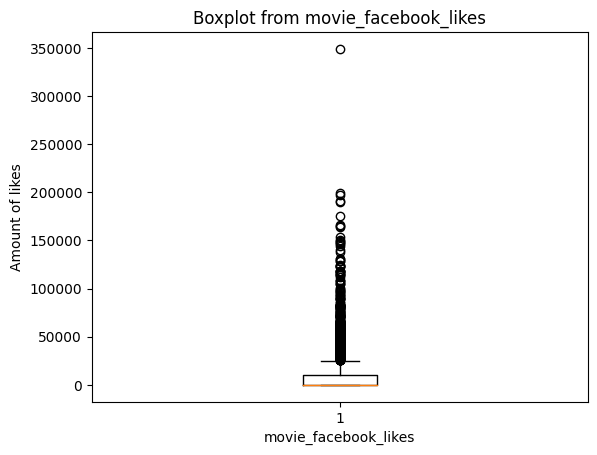

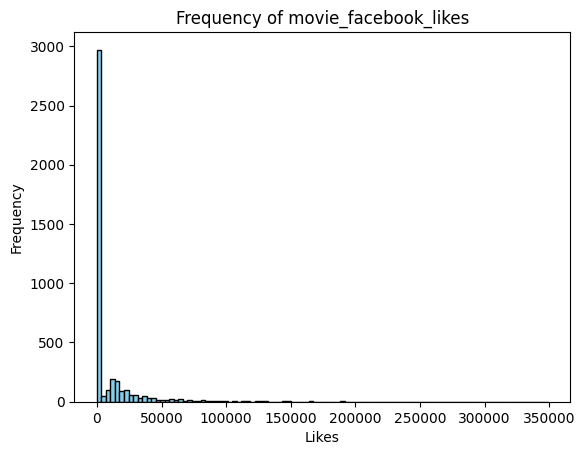

In [12]:
#Boxplots en histogrammen plotten
fn.boxplot_gross_and_budget(df, 'gross')
fn.histogram_gross(df, 'gross')

for feature in featureVariables:
    if 'like' in feature:
        fn.boxplot_likes(df, feature)
        fn.histogram_likes(df, feature)

## Onderzoeksvraag 1: In hoeverre is de omzet van een film te voorspellen op basis van de populariteit op Facebook en IMDB


We gaan hier met scatterplots onderzoeken wat de relatie is tussen het aantal Facebook-likes van de regisseur, de acteurs, de film, de IMDb-score en de hele cast en de totale opbrengst van de film.

**Scatterplots**

Bereken de feature variabelen tegenover de doelvariabele, zodat we kunnen zien welke kenmerken (enigszins) belangrijk zijn voor de doelvariabele

Zoals je kunt aflezen is er geen enkele feature variabele die met zekerheid een positieve correlatie heeft. De hoogste heeft een 0.38 wat maar een matige positieve correlatie weergeeft.

We vermoeden dan ook dat het linieare regressie model het niet uitstekend zal doen.

In [13]:
correlation = df[featureVariables + targetVariable].corr()['gross'].sort_values(ascending=False)
print(correlation)

gross                       1.00
movie_facebook_likes        0.38
actor_3_facebook_likes      0.31
actor_2_facebook_likes      0.26
cast_total_facebook_likes   0.25
imdb_score                  0.20
actor_1_facebook_likes      0.15
director_facebook_likes     0.14
Name: gross, dtype: float64


**In alle plots hieronder staat bij X-as de Totale filmopbrengsten**

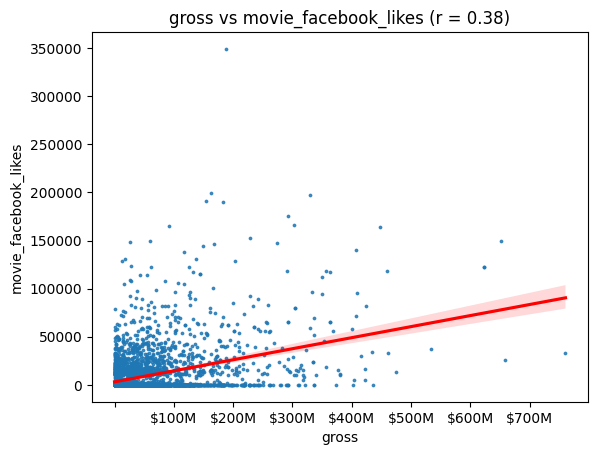

In [14]:
fn.correlation_plot(df, 'gross', 'movie_facebook_likes')

- Y-as: Aantal Facebook likes

- De likes toeneemt wanneer filmopbregnsten toeneemt, betekent dat films met meer Facebook likes meestal ook hogere opbrengsten hebben. De meeste datapunten verzamelen in linkerbenedenhoek, we kunnen dus zeggen minder dan 200 miljoen dollar opbrengsten zijn de Facebook-likes meestal minder dan 50.000. Aangezien de betrouwbaarheidsintervallen, hoe hoger de opbrengsten, hoe minder we met de Facebook-likes de opbrengsten kan voorspellen

- In het plot zien we een positieve correlatie 0.38, de rode trendlijn toont ook een lichte positieve correlatie. 

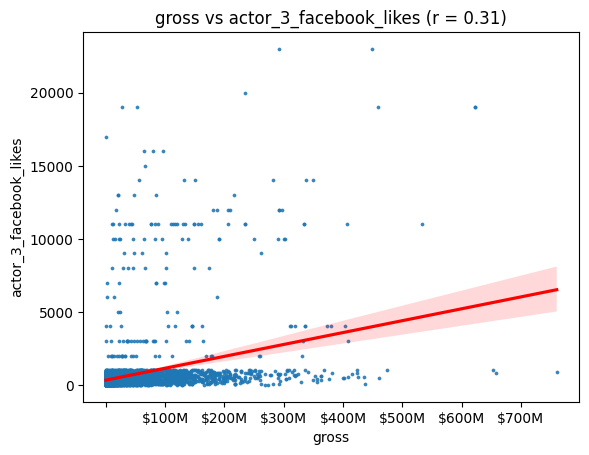

In [15]:
fn.correlation_plot(df, 'gross', 'actor_3_facebook_likes')

- Y-as: Aantal Facebook likes van Acteur 3

- De meeste punten zijn linkerbeneden minder dan 200 miljoen dollar en onder 5000 likes. hoe groter de opbrengsten hoe groter de betrouwbaarheidsintervallen. Dus hoe groter de opbrengsten van de film heeft, dan dan hoe weiniger mee te maken met acteur 3. 

- In het plot zien we een positieve correlatie 0.31, betekent dan een matige correlatie maar hier heeft eigenlijk weinig zin om verder te onderzoeken.


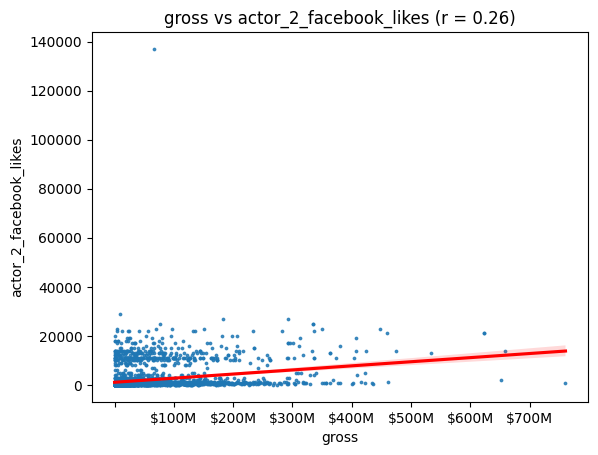

In [16]:
fn.correlation_plot(df, 'gross', 'actor_2_facebook_likes')

- Y-as: Aantal Facebook likes van Acteur 2

- De meeste punten zijn nog steeds in de linkerbenedenhoek minder dan 200 miljoen dollar en onder 20000 likes, een uitschieter op 140000 likes zorgt ook niet voor een hogere opbrengst. De helling van de trendlijn is erg klein, betekent ook als de opbrengsten toeneemt is de likes van acteur 2 niet hoog.

- In het plot zien we een positieve correlatie 0.26, een lichte correlatie, maar ook geen waarde om verder te onderzoeken.

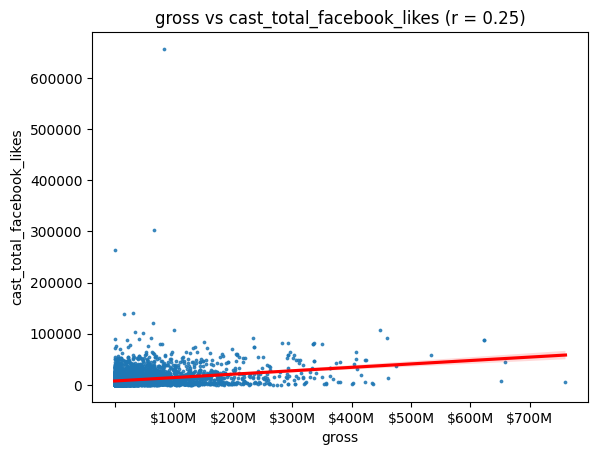

In [17]:
fn.correlation_plot(df, 'gross', 'cast_total_facebook_likes')

- Y-as: Aantal Facebook likes van cast

- De meeste punten zijn nog steeds in de linkerbenedenhoek minder dan 200 miljoen dollar en onder 100 000 likes, de helling van de trendlijn is ook heel klein.

- In het plot zien we een positieve correlatie 0.25, beetje zwak.

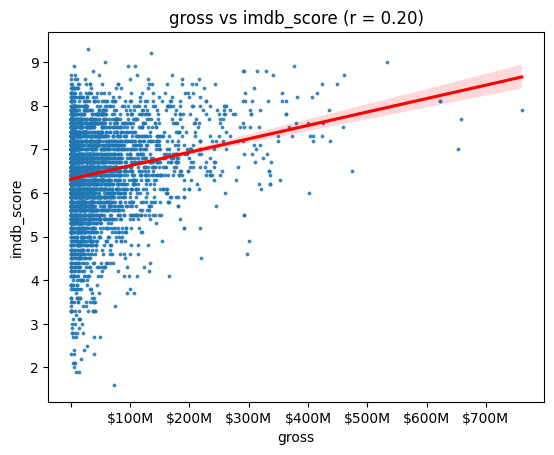

In [18]:
fn.correlation_plot(df, 'gross', 'imdb_score')

- Y-as: IMDb-score

- De meeste film heeft een IMDb-score tussen 5 en 8, en de meeste films hebben een opbrengst van minder dan 200 miljoen dollar. Hoe groter de opbrengsten hoe groter de betrouwbaarheidsintervallen en dus hoe moeilijker om te voorspellen.

- In het plot zien we een positieve correlatie 0.20, zwak.

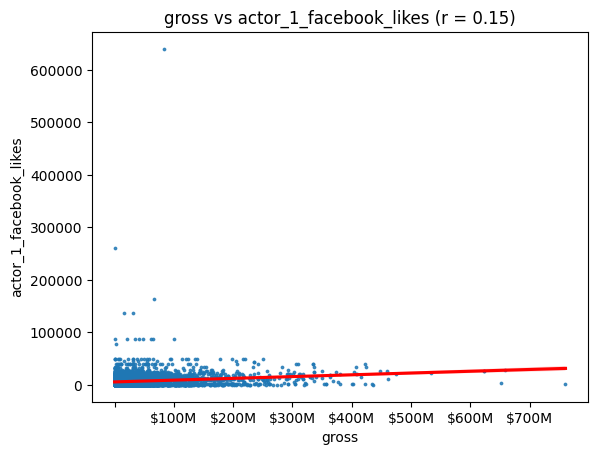

In [19]:
fn.correlation_plot(df, 'gross', 'actor_1_facebook_likes')

- Y-as: Aantal Facebook likes van Acteur 1

- De meeste punten zijn nog steeds in de linkerbenedenhoek minder dan 200 miljoen dollar en onder 100 000 likes, de helling van de trendlijn is ook heel klein. Zoals bij de Facebook-likes van acteur 2 en cast.

- In het plot zien we een positieve correlatie 0.15, zwak, zwak.

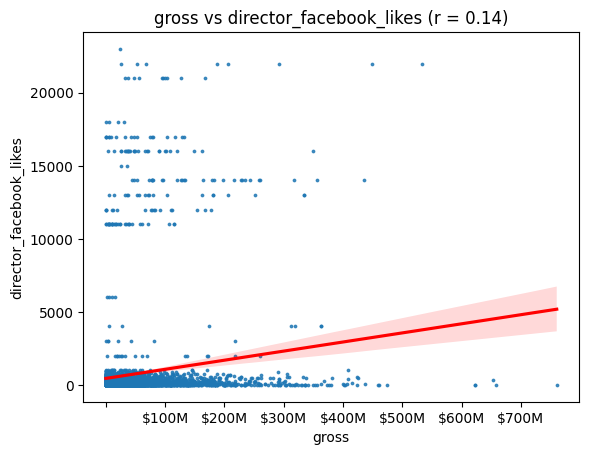

In [20]:
fn.correlation_plot(df, 'gross', 'director_facebook_likes')

- Y-as: Aantal Facebook likes van directeur

- De meeste datapunten verzamelen linksbeneden, er zijn Facebook-likes van directeur die meer dan 10000 maar geen invloed heeft op de opbrengsten van de film. Hoe groter de opbrengsten hoe groter de betrouwbaarheidsintervallen. Dus de opbrengesten heeft weinig mee te maken met hoe bekend de directeur is.

- In het plot zien we een positieve correlatie 0.14, zwak, zwak.

Nu wijzen we dummy variabelen aan aan de namen van de directeuren en acteuren.

In [21]:
#Selecteer numerieke kenmerkenvariabelen
numeric = df[['director_facebook_likes', 
                'actor_1_facebook_likes', 
                'actor_2_facebook_likes', 
                'actor_3_facebook_likes', 
                'cast_total_facebook_likes', 'movie_facebook_likes', 'imdb_score',
                'gross'
                ]]

#We wijzen alle andere kolomwaarden toe aan dummywaarden. dfr is aan het begin gemaakt voor dataframe real (de hele dataset).
dummies = pd.get_dummies(dfr[['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']], dtype = int)

#Voer de samenvoeging van de twee dataframes uit tot 1 dataframe. dfd staat voor dataframe dummies
dfd = pd.concat([numeric, dummies], axis = 1)

Na het aanmaken van alle dummies zie je dat er heel wat kolommen bij zijn gekomen. Dit komt doordat waar een 1 staat bij de naam, deze de acteur facebook likes representeert en een 0 voor niet.

In [22]:
dfd.shape

(5043, 11056)

### We gaan nu kijken naar alle likestatistieken per regisseur en acteur

Zoals je kunt zien, zijn er veel regisseurs en acteurs met grote films (hoge inkomsten) die nul likes krijgen op hun Facebook-pagina. Dit is vooral het geval bij regisseurs. We zullen hier uiteindelijk niks mee doen. Stel dat we deze waarden gaan invullen met het gemiddelde aantal likes van vergelijkbare films, gegroepeerd op basis van hun 'gross', dan kunnen wij handmatig een trend in de data stoppen die er misschien helemaal niet is.

In [23]:
likeList = []
grossList = []

for column in dfd.columns:
    if 'director_name' in column:

        rowsWithDirector = dfd[dfd[column] == 1]

        infoLikes = rowsWithDirector[['director_facebook_likes']]
        infoGross = rowsWithDirector[['gross']]

        describeLikeStats = infoLikes.describe(include='all').transpose()
        describeGrossStats = infoGross.describe(include='all').transpose()

        describeLikeStats = describeLikeStats.add_prefix('likes_')
        describeGrossStats = describeGrossStats.add_prefix('gross_')

        describeLikeStats['director'] = column
        describeGrossStats['director'] = column

        likeList.append(describeLikeStats)
        grossList.append(describeGrossStats)

directorLikeStats = pd.concat(likeList).reset_index(drop=True)
directorGrossStats = pd.concat(grossList).reset_index(drop=True)

directorStats = pd.merge(directorLikeStats, directorGrossStats, on='director', how='outer')

directorStats = directorStats.sort_values(by='likes_mean', ascending=True)

directorStats.head(10)
        

,likes_count,likes_mean,likes_std,likes_min,likes_25%,likes_50%,likes_75%,likes_max,director,gross_count,gross_mean,gross_std,gross_min,gross_25%,gross_50%,gross_75%,gross_max
751,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,director_name_Gene Quintano,1.00,"27,979,400.00",NaN,"27,979,400.00","27,979,400.00","27,979,400.00","27,979,400.00","27,979,400.00"
1751,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,director_name_Paul Thomas Anderson,6.00,"21,886,070.00","10,899,612.02","8,093,318.00","16,730,713.25","20,121,003.00","25,401,433.00","40,218,903.00"
1074,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,director_name_Joel Edgerton,2.00,"43,771,291.00",0.00,"43,771,291.00","43,771,291.00","43,771,291.00","43,771,291.00","43,771,291.00"
1073,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,director_name_Joel Coen,4.00,"25,227,835.25","18,878,364.37","2,869,369.00","13,796,714.50","26,267,676.50","37,698,797.25","45,506,619.00"
1759,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,director_name_Pedro Almodóvar,1.00,"12,899,702.00",NaN,"12,899,702.00","12,899,702.00","12,899,702.00","12,899,702.00","12,899,702.00"
1054,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,director_name_Jodie Foster,3.00,"19,828,357.00","20,124,796.65","958,319.00","9,238,269.50","17,518,220.00","29,263,376.00","41,008,532.00"
1764,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,director_name_Pete Docter,3.00,"313,113,780.33","37,565,467.49","289,907,418.00","291,443,487.00","292,979,556.00","324,716,961.50","356,454,367.00"
302,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,director_name_Catherine Gund,1.00,"21,199.00",NaN,"21,199.00","21,199.00","21,199.00","21,199.00","21,199.00"
1769,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,director_name_Peter Billingsley,1.00,"109,176,215.00",NaN,"109,176,215.00","109,176,215.00","109,176,215.00","109,176,215.00","109,176,215.00"
597,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,director_name_Doug Block,1.00,"84,689.00",NaN,"84,689.00","84,689.00","84,689.00","84,689.00","84,689.00"


In [24]:
likeActor1List = []
grossActor1List = []

for column in dfd.columns:
    if 'actor_1' in column:

        rowsWithActor1 = dfd[dfd[column] == 1]

        infoLikes = rowsWithActor1[['actor_1_facebook_likes']]
        infoGross = rowsWithActor1[['gross']]

        describeLikeStats = infoLikes.describe(include='all').transpose()
        describeGrossStats = infoGross.describe(include='all').transpose()

        describeLikeStats = describeLikeStats.add_prefix('likes_')
        describeGrossStats = describeGrossStats.add_prefix('gross_')

        describeLikeStats['actor1'] = column
        describeGrossStats['actor1'] = column
        
        likeActor1List.append(describeLikeStats)
        grossActor1List.append(describeGrossStats)

actor1LikeStats = pd.concat(likeActor1List).reset_index(drop=True)
actor1GrossStats = pd.concat(grossActor1List).reset_index(drop=True)

actor1Stats = pd.merge(actor1LikeStats, actor1GrossStats, on='actor1', how='outer')

actor1Stats = actor1Stats.sort_values(by='likes_mean', ascending=True)

actor1Stats.head(10)

,likes_count,likes_mean,likes_std,likes_min,likes_25%,likes_50%,likes_75%,likes_max,actor1,gross_count,gross_mean,gross_std,gross_min,gross_25%,gross_50%,gross_75%,gross_max
727,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_1_name_Heather Berman,1.00,"8,044,906.00",NaN,"8,044,906.00","8,044,906.00","8,044,906.00","8,044,906.00","8,044,906.00"
1992,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_1_name_Tshewang Dendup,1.00,"505,295.00",NaN,"505,295.00","505,295.00","505,295.00","505,295.00","505,295.00"
80,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_1_name_Ami Ayalon,1.00,"2,408,553.00",NaN,"2,408,553.00","2,408,553.00","2,408,553.00","2,408,553.00","2,408,553.00"
282,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_1_name_Carol Block,1.00,"84,689.00",NaN,"84,689.00","84,689.00","84,689.00","84,689.00","84,689.00"
321,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_1_name_Chemeeka Walker,1.00,"11,529,368.00",NaN,"11,529,368.00","11,529,368.00","11,529,368.00","11,529,368.00","11,529,368.00"
128,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_1_name_Ariel Hsing,1.00,"5,858.00",NaN,"5,858.00","5,858.00","5,858.00","5,858.00","5,858.00"
571,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_1_name_Elizabeth Streb,1.00,"21,199.00",NaN,"21,199.00","21,199.00","21,199.00","21,199.00","21,199.00"
1437,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_1_name_Naderev Sano,1.00,"4,914.00",NaN,"4,914.00","4,914.00","4,914.00","4,914.00","4,914.00"
753,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_1_name_Ian Gamazon,1.00,"70,071.00",NaN,"70,071.00","70,071.00","70,071.00","70,071.00","70,071.00"
1854,1.00,2.00,NaN,2.00,2.00,2.00,2.00,2.00,actor_1_name_Stephen Carr,1.00,"3,000,000.00",NaN,"3,000,000.00","3,000,000.00","3,000,000.00","3,000,000.00","3,000,000.00"


In [25]:
likeActor2List = []
grossActor2List = []

for column in dfd.columns:
    if 'actor_2' in column:

        rowsWithActor2 = dfd[dfd[column] == 1]

        infoLikes = rowsWithActor2[['actor_2_facebook_likes']]
        infoGross = rowsWithActor2[['gross']]

        describeLikeStats = infoLikes.describe(include='all').transpose()
        describeGrossStats = infoGross.describe(include='all').transpose()

        describeLikeStats = describeLikeStats.add_prefix('likes_')
        describeGrossStats = describeGrossStats.add_prefix('gross_')

        describeLikeStats['actor2'] = column
        describeGrossStats['actor2'] = column
        
        likeActor2List.append(describeLikeStats)
        grossActor2List.append(describeGrossStats)

actor2LikeStats = pd.concat(likeActor2List).reset_index(drop=True)
actor2GrossStats = pd.concat(grossActor2List).reset_index(drop=True)

actor2Stats = pd.merge(actor2LikeStats, actor2GrossStats, on='actor2', how='outer')

actor2Stats = actor2Stats.sort_values(by='likes_mean', ascending=True)

actor2Stats.head(10)

,likes_count,likes_mean,likes_std,likes_min,likes_25%,likes_50%,likes_75%,likes_max,actor2,gross_count,gross_mean,gross_std,gross_min,gross_25%,gross_50%,gross_75%,gross_max
3032,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_2_name_Zubaida Sahar,1.00,"1,127,331.00",NaN,"1,127,331.00","1,127,331.00","1,127,331.00","1,127,331.00","1,127,331.00"
848,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_2_name_Edgar Tancangco,1.00,"70,071.00",NaN,"70,071.00","70,071.00","70,071.00","70,071.00","70,071.00"
880,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_2_name_Ellen Block,1.00,"84,689.00",NaN,"84,689.00","84,689.00","84,689.00","84,689.00","84,689.00"
935,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_2_name_Eva Carrozza,1.00,"8,044,906.00",NaN,"8,044,906.00","8,044,906.00","8,044,906.00","8,044,906.00","8,044,906.00"
942,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_2_name_Evelyn Jefferson,1.00,"1,111.00",NaN,"1,111.00","1,111.00","1,111.00","1,111.00","1,111.00"
2485,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_2_name_Ronny Dayag,1.00,"2,283,276.00",NaN,"2,283,276.00","2,283,276.00","2,283,276.00","2,283,276.00","2,283,276.00"
2899,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_2_name_Val Kilmer,1.00,"17,473,245.00",NaN,"17,473,245.00","17,473,245.00","17,473,245.00","17,473,245.00","17,473,245.00"
2405,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_2_name_Richard Linklater,1.00,"1,227,508.00",NaN,"1,227,508.00","1,227,508.00","1,227,508.00","1,227,508.00","1,227,508.00"
1085,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_2_name_Guillaume Denaiffe,1.00,"4,074,023.00",NaN,"4,074,023.00","4,074,023.00","4,074,023.00","4,074,023.00","4,074,023.00"
793,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_2_name_Donald Austin,1.00,"111,300.00",NaN,"111,300.00","111,300.00","111,300.00","111,300.00","111,300.00"


In [26]:
likeActor3List = []
grossActor3List = []

for column in dfd.columns:
    if 'actor_3' in column:
        rowsWithActor3 = dfd[dfd[column] == 1]

        infoLikes = rowsWithActor3[['actor_3_facebook_likes']]
        infoGross = rowsWithActor3[['gross']]

        describeLikeStats = infoLikes.describe(include='all').transpose()
        describeGrossStats = infoGross.describe(include='all').transpose()

        describeLikeStats = describeLikeStats.add_prefix('likes_')
        describeGrossStats = describeGrossStats.add_prefix('gross_')

        describeLikeStats['actor3'] = column
        describeGrossStats['actor3'] = column
        
        likeActor3List.append(describeLikeStats)
        grossActor3List.append(describeGrossStats)

actor3LikeStats = pd.concat(likeActor3List).reset_index(drop=True)
actor3GrossStats = pd.concat(grossActor3List).reset_index(drop=True)

actor3Stats = pd.merge(actor3LikeStats, actor3GrossStats, on='actor3', how='outer')

actor3Stats = actor3Stats.sort_values(by='likes_mean', ascending=True)

actor3Stats.head(10)

,likes_count,likes_mean,likes_std,likes_min,likes_25%,likes_50%,likes_75%,likes_max,actor3,gross_count,gross_mean,gross_std,gross_min,gross_25%,gross_50%,gross_75%,gross_max
2419,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_3_name_Mike Brett,1.00,"4,914.00",NaN,"4,914.00","4,914.00","4,914.00","4,914.00","4,914.00"
2794,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_3_name_Renee Leblanc,1.00,"592,014.00",NaN,"592,014.00","592,014.00","592,014.00","592,014.00","592,014.00"
2455,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_3_name_Mohamad Haref Harati,1.00,"1,127,331.00",NaN,"1,127,331.00","1,127,331.00","1,127,331.00","1,127,331.00","1,127,331.00"
586,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_3_name_Chloe Hollings,1.00,"4,074,023.00",NaN,"4,074,023.00","4,074,023.00","4,074,023.00","4,074,023.00","4,074,023.00"
3149,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_3_name_Steve Burg,1.00,"12,995,673.00",NaN,"12,995,673.00","12,995,673.00","12,995,673.00","12,995,673.00","12,995,673.00"
1718,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_3_name_John Reeves,1.00,"1,111.00",NaN,"1,111.00","1,111.00","1,111.00","1,111.00","1,111.00"
3125,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_3_name_Stellan Skarsgård,1.00,"64,148.00",NaN,"64,148.00","64,148.00","64,148.00","64,148.00","64,148.00"
2820,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_3_name_Richard Spore,1.00,"203,134.00",NaN,"203,134.00","203,134.00","203,134.00","203,134.00","203,134.00"
213,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_3_name_Anna Vareschi,1.00,"365,734.00",NaN,"365,734.00","365,734.00","365,734.00","365,734.00","365,734.00"
467,1.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,actor_3_name_Béatrice Bonifassi,1.00,"7,002,255.00",NaN,"7,002,255.00","7,002,255.00","7,002,255.00","7,002,255.00","7,002,255.00"


## Modellen ##

Hier gaan we de modellen toepassen op onze data. 

Als eerst gaan we een train test split maken.

In [27]:
X = df[featureVariables]
y = df[targetVariable]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

Baseline.

Een baseline score is nodig om te kijken hoe ver onze modellen hiervan afwijken. Als de score van ons complexere model eronder zit doet het model het beter dan de baseline model wat goed is, als de score erboven zit doet het model het slechter en is dit een reden om dat model niet te gaan gebruiken.

De baseline bereken je met de 'mean_squared_error' uitgedrukt in RMSE. 

De baseline score geeft ons een referentie voor onze modelprestaties. Elk model dat op zijn minst beter presteert dan deze baseline is een verbetering.

In [28]:
# Dit gemiddelde word als de "baseline" voorspelling gebruikt voor alle tests.
baseline = np.mean(y_train)

# Dit betekent dat elke voorspelling hetzelfde is en gelijk is aan het gemiddelde van y_train.
y_pred = np.ones(len(X_test)) * baseline

# 'squared=False' geeft aan dat de wortel van de mean squared errror word genomen, zodat je de RMSE krijgt.
baseline_score = mean_squared_error(y_test, y_pred, squared=False)

print(f"RMSE: {baseline_score:.2f}")

RMSE: 69771005.94


C:\Users\pim-d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Als eerst gaan we linieare regressie toepassen. 
De data gaan we ook normaliseren. Normaliseren is nodig om het linieare regressie model beter te laten werken omdat het model werkt op relatieve afstanden van elkaar.
Bij dit model hebben we niet gekozen voor hyperparameters, dit model is vrij simpel en geeft alleen een directe oplossing door de normale vergelijking.

De uitkomst van dit model is 58977858.91 en zit met 14,94% onder het baseline model wat goed is. 
de R-squared is 0.29. Dit model kan ongeveer 29% van de variatie in de variabele kan verklaren. Dit is niet al te best. Dit duid op een niet linieare relatie. (dit hadden we ook gezien bij de correlatie plots)

In [29]:
scaler = StandardScaler()

# Een genormaliseerde train en test maken
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
# Maak een lineaire regressie model aan
lr = lm.LinearRegression()

# Fit het model met de trainings data
lr.fit(X_train_scaled, y_train)

# Bereken de voorspellingen voor de test data
y_pred = lr.predict(X_test_scaled)

# Bereken de RMSE
lr_score = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error: {lr_score:.2f}")

# Bereken de R^2 score voor het regressiemodel
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.2f}")

Root Mean Squared Error: 58977858.91
R-squared: 0.29


C:\Users\pim-d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Hier gaan we KNN toepassen. De hyperparameters zijn n_neighbors=5, weights="distance", p=2
We hebben gekozen voor N_neighbors=5 want hier zit de 'knik'. Dit betekent dat dit het 'beste' model is zonder te overfitten.
Ook hebben we gekozen voor p=2. Dit neemt de euclidische afstand, ipv p=1 de minkowski afstand. Dit geeft voor onze dataset het beste resultaat.

De uitkomst van dit model is 60222465.80, wat met 12,98% boven het baseline model zit wat goed is. En een R-squared van 0.25 wat aangeeft dat dit model ongeveer 28% van de variatie in de variabele kan verklaren wat slecht is. Dit is niet al te best. Dit duid op een niet linieare relatie. (dit hadden we ook gezien bij de correlatie plots)

C:\Users\pim-d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\pim-d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\pim-d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mea

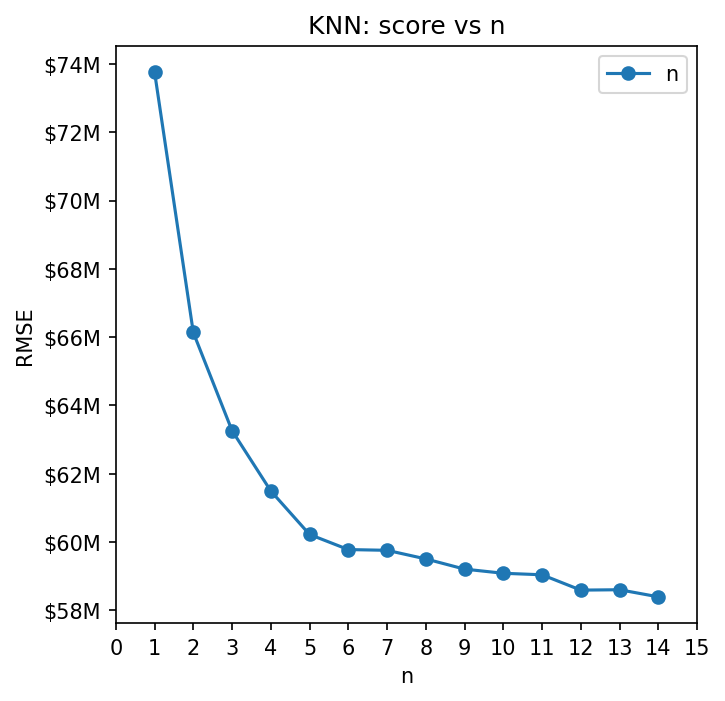

In [31]:
# Code uit de les van CM09
data = []

max_n = 15

for i in range(1, max_n):
    knn = KNeighborsRegressor(n_neighbors=i, weights="distance", p=2)

    # Fitten met trainingsdaata
    knn.fit(X_train_scaled, y_train)

    # Bereken de voorspellingen
    y_pred = knn.predict(X_test_scaled)

    # Bereken de RMSE
    knn_score = mean_squared_error(y_test, y_pred, squared=False)

    data.append([i, knn_score])

df_knn = pd.DataFrame(data, columns=['n', 'RMSE'])

fig = plt.figure(figsize=(5,5), dpi=150)

ax = plt.axes()

ax.set(xlim=(0,max_n),
       xlabel='n',
       ylabel='RMSE',
       title='KNN: score vs n')

ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.ticklabel_format(useOffset=False)
ax.plot(df_knn['n'], df_knn['RMSE'], '-o')

ax.yaxis.set_major_formatter(FuncFormatter(fn.euro_formatter))

ax.legend(['n'])

In [32]:
# KNN regressie model met hyperparameters
knn = KNeighborsRegressor(n_neighbors=5, weights="distance", p=2)

# Fitten met trainingsdaata
knn.fit(X_train_scaled, y_train)

# Bereken de voorspellingen
y_pred = knn.predict(X_test_scaled)

# Bereken de RMSE
knn_score = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error: {knn_score:.2f}")

# Bereken de R^2 score voor het KNN model
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.2f}")

Root Mean Squared Error: 60222465.80
R-squared: 0.25


C:\Users\pim-d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Decision Tree Regressor**

We passen nu een decision tree regressor toe. Deze keuze hebben we gemaakt omdat deze beter om zou moeten kunnen gaan met niet lineare verbanden. Wat goed uitkomt want uit ons correlatie onderzoek is een slechte correlatie gekomen. We hoeven ook geen gebruik te maken van een scalar om te normaliseren. Een DTR kan hiermee omgaan.

We gebruiken max_depth=4 omdat dit het 'beste' model is wat we hebben. Zelfs door veel verder te gaan in de boom wordt de score alleen maar slechter.

De uitkomst van dit model is 62424735.88, wat met 10,52% boven het baseline model zit wat goed is. En een R-squared van 0.19 wat aangeeft dat dit model ongeveer 19% van de variatie in de variabele kan verklaren wat slecht is. Dit is niet al te best. Dit duid op een niet linieare relatie. (dit hadden we ook gezien bij de correlatie plots)

In [33]:
# Data splitsen in train en test sets
X_train, X_test, y_train, y_test = train_test_split(df[featureVariables], df[targetVariable], test_size=0.2, random_state=42)

# Decision Tree Regressor initialiseren en trainen
tree_regressor = DecisionTreeRegressor(max_depth=4,random_state=42)
tree_regressor.fit(X_train, y_train)

# Voorspellingen doen op de test set
y_pred = tree_regressor.predict(X_test)

# Evaluatie van het model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Bereken de R^2 score voor het KNN model
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.2f}")

Root Mean Squared Error (RMSE): 62424735.88
R-squared: 0.19


Hier bekijken we welke hyperparameters we moeten gebruiken

C:\Users\pim-d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\pim-d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\pim-d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mea

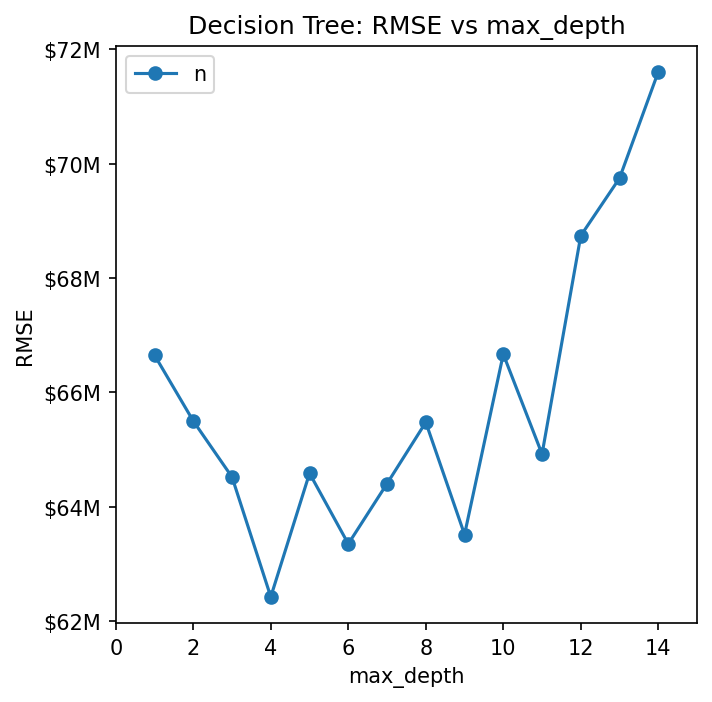

In [34]:
data = []

max_depth = 15

for i in range(1, max_depth):
    # DTR met alle max_depths
    tree = DecisionTreeRegressor(max_depth=i, random_state=42)
    
    # Fitten met niet gescalede data
    tree.fit(X_train, y_train)
    
    # Bereken de voorspellingen
    y_pred = tree.predict(X_test)
    
    # Bereken de RMSE
    tree_score = mean_squared_error(y_test, y_pred, squared=False)
    
    data.append([i, tree_score])

df_tree = pd.DataFrame(data, columns=['max_depth', 'RMSE'])

# Plotten van de resultaten
fig = plt.figure(figsize=(5, 5), dpi=150)
ax = plt.axes()

# Instellen van de plotlimieten en labels
ax.set(xlim=(0, max_depth),
       xlabel='max_depth',
       ylabel='RMSE',
       title='Decision Tree: RMSE vs max_depth')

ax.plot(df_tree['max_depth'], df_tree['RMSE'], '-o')

ax.yaxis.set_major_formatter(FuncFormatter(fn.euro_formatter))

ax.legend(['n'])

plt.show()

Visualiseer de tree.

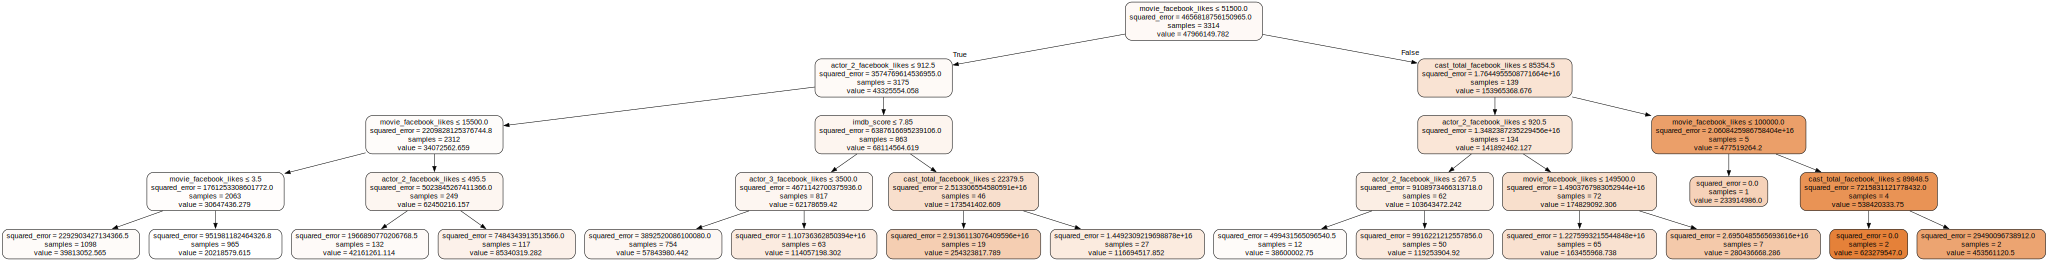

In [35]:
# Code van les CM05
data = export_graphviz(tree_regressor, out_file=None, feature_names=featureVariables, class_names=targetVariable,   
                         filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(data)
graph

## Conclusie onderzoeksvraag 1

Het lineaire regressiemodel presteert beter dan zowel het baseline model als het KNN model, met een 14,94% lagere RMSE ten opzichte van het baseline model. De lage R-squared waarde van 0.29 van het lineaire model geeft echter aan dat er veel variatie in de omzet niet verklaard kan worden door onze gebruikte features. Overigens is het bij de andere 2 modellen (KNN en DTR) nog slechter.

Hiermee concluderen we dat de omzet van een film niet te voorspellen is op basis van de populariteit op facebook en IMDB.

## Onderzoeksvraag 2: Is het mogelijk om te voorspellen of een film een oscar zal winnen of niet?

Een oscar winnen is een hele eer in de filmindustrie. Het is dus zeer interessant of we wellicht een model kunnen bouwen welke film een oscar zou winnen of niet. Wellicht kunnen we zo een accuraat model bouwen dat het miljarden waard zou zijn. En aangezien elke regrisseur die gefocust is op roem dit graag zou willen weten. Laten we van start gaan! En wellicht rijk worden!

In [36]:
# Inladen db

oscar_db = pd.read_csv('data/the_oscar_award.csv')

In [37]:
# Check of alles correct is ingeladen

oscar_db.sample(5)

,year_film,year_ceremony,ceremony,category,name,film,winner
4332,1966,1967,39,ACTOR IN A SUPPORTING ROLE,Mako,The Sand Pebbles,False
2729,1952,1953,25,SOUND RECORDING,"Samuel Goldwyn Studio Sound Department, Gordon...",Hans Christian Andersen,False
10719,2022,2023,95,BEST PICTURE,"Kristie Macosko Krieger, Steven Spielberg and ...",The Fabelmans,False
3443,1958,1959,31,BEST MOTION PICTURE,"Stanley Kramer, Producer",The Defiant Ones,False
4890,1971,1972,44,ACTRESS,Julie Christie,McCabe & Mrs. Miller,False


We zien hier 7 tabellen terug de Target waarop wij gaan focussen is de 'Winner' tabel. Daarin kunnen we zien of een film een oscar heeft gewonnen of niet.

In [38]:
oscar_db.describe()

,year_film,year_ceremony,ceremony
count,"10,889.00","10,889.00","10,889.00"
mean,"1,976.61","1,977.61",49.63
std,27.36,27.36,27.32
min,"1,927.00","1,928.00",1.00
25%,"1,952.00","1,953.00",25.00
50%,"1,976.00","1,977.00",49.00
75%,"2,001.00","2,002.00",74.00
max,"2,023.00","2,024.00",96.00


Hieruit volgt dat tabel 'ceremony' gewoonweg bijhoudt hoeveel keer de oscar awards zijn gehouden.

In [39]:
oscar_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10889 entries, 0 to 10888
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year_film      10889 non-null  int64 
 1   year_ceremony  10889 non-null  int64 
 2   ceremony       10889 non-null  int64 
 3   category       10889 non-null  object
 4   name           10884 non-null  object
 5   film           10570 non-null  object
 6   winner         10889 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 521.2+ KB


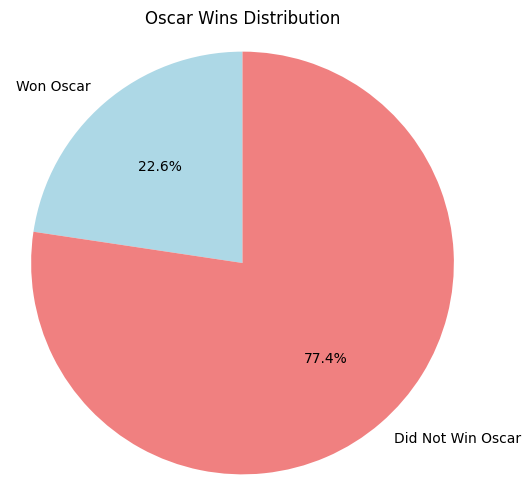

In [40]:
# Check hoeveel True en False er zijn in de Winner tabel
true_count = oscar_db['winner'].value_counts()[True]
false_count = oscar_db['winner'].value_counts()[False]

# Benaming voor de taart diagram
labels = ['Won Oscar', 'Did Not Win Oscar']

# Data om te plotten
sizes = [true_count, false_count]

# Maak taart diagram
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Oscar Wins Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

We zien dus dat minder dan een vierde van de genomineerde een Oscar wint. Maar waar we natuurlijk ook naar moeten kijken is hoe groot de kans is om uberhaupt genomineerd te worden. Daarvoor zullen we de 2 datasets moeten mergen. 

### Databases mergen

We gaan de databases mergen op de 'movie_titel' tabel en de 'name' tabel. We joinen met 'left'.

In [41]:
# Zet de datatypes om naar strings

dfr['movie_title'] = dfr['movie_title'].astype(str)
oscar_db['film'] = oscar_db['film'].astype(str) 

# Normaliseer de data
dfr['movie_title'] = dfr['movie_title'].str.strip().str.lower()
oscar_db['film'] = oscar_db['film'].str.strip().str.lower()

In [42]:
oscar_db['film'].sample(5)

10540                   dune
1495     so proudly we hail!
7669             the apostle
9040     the secret of kells
10164                  mirai
Name: film, dtype: object

In [43]:
dfr['movie_title'].sample(5)

3482             logan's run
1225      behind enemy lines
5023        breaking upwards
2506                     atl
3776    90 minutes in heaven
Name: movie_title, dtype: object

In [44]:
merged_df = pd.merge(dfr, oscar_db, left_on='movie_title', right_on='film', how='left')

In [45]:
merged_df.sample(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,year_film,year_ceremony,ceremony,category,name,film,winner
6697,Color,Morgan Spurlock,130.00,90.00,293.00,808.00,J.J. Abrams,"16,000.00","638,476.00",Comedy|Documentary,Quentin Tarantino,the greatest movie ever sold,13223,32405,Donald Trump,1.00,advertising|movie in title|product placement,http://www.imdb.com/title/tt1743720/?ref_=fn_t...,45.00,English,USA,PG-13,"1,500,000.00","2,011.00","14,000.00",6.60,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4288,Color,Tony Jaa,110.00,110.00,0.00,7.00,Petchtai Wongkamlao,64.00,"102,055.00",Action,Nirut Sirichanya,ong-bak 2,24570,134,Sarunyu Wongkrachang,0.00,cult film|elephant|jungle|martial arts|stylize...,http://www.imdb.com/title/tt0785035/?ref_=fn_t...,72.00,Thai,Thailand,R,"300,000,000.00","2,008.00",45.00,6.20,2.35,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3880,Color,Sam Raimi,125.00,121.00,0.00,244.00,Bridget Fonda,989.00,"16,311,763.00",Crime|Drama|Thriller,Gary Cole,a simple plan,50656,2365,Chelcie Ross,1.00,bag of money|found money|minnesota|screenplay ...,http://www.imdb.com/title/tt0120324/?ref_=fn_t...,416.00,English,UK,R,"17,000,000.00","1,998.00",888.00,7.50,1.85,0,"1,998.00","1,999.00",71.00,WRITING (Screenplay Based on Material Previous...,Scott B. Smith,a simple plan,False
6797,Color,Adam Green,229.00,93.00,134.00,488.00,Kane Hodder,936.00,NaN,Comedy|Horror,Joel David Moore,hatchet,23349,3668,Joel Murray,0.00,bayou|boat|louisiana|swamp|tour,http://www.imdb.com/title/tt0422401/?ref_=fn_t...,235.00,English,USA,R,"1,500,000.00","2,006.00",935.00,5.70,1.85,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2113,Color,David Carson,98.00,118.00,18.00,906.00,Alan Ruck,"1,000.00","75,668,868.00",Action|Adventure|Mystery|Sci-Fi|Thriller,LeVar Burton,star trek: generations,60504,6427,Jonathan Frakes,0.00,23rd century|bare chested male bondage|enterpr...,http://www.imdb.com/title/tt0111280/?ref_=fn_t...,249.00,English,USA,PG,"35,000,000.00","1,994.00",946.00,6.60,2.35,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We zien veel NaN waardes bij de kolom film/winner/name. We kunnen er dus vanuit gaan dat deze films niet zijn genomineerd. Laten we een nieuwe categorie maken om dit duidelijk te maken. 

In [46]:
# Voeg een nieuwe kolom toe voor de categorieën
merged_df['categorie'] = merged_df['winner'].apply(
    lambda x: 'Oscar gewonnen' if x == True else ('Oscar genomineerd' if x == False else 'Niet genomineerd')
)

Laten we data nu visualiseren om een mooi beeld te krijgen.

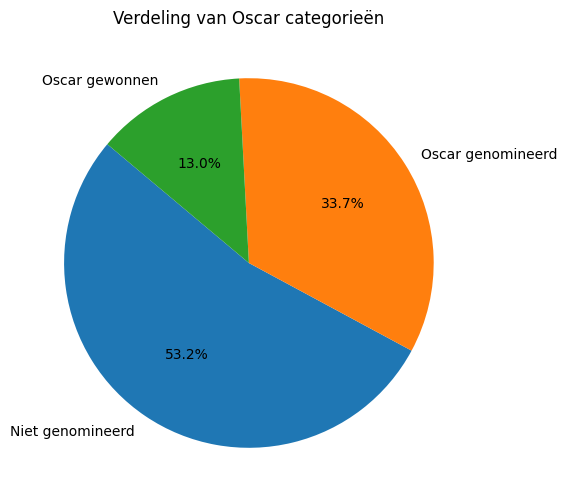

In [47]:
# Data visualiseren
categorie_counts = merged_df['categorie'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(categorie_counts, labels=categorie_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Verdeling van Oscar categorieën')
plt.show()

We zien hier dat slechts 13% van alle films in onze dataframe een Oscar wint. Laten we nu dieper in de data kijken waarom dit het geval zou kunnen zijn.

In [48]:
# Check welke columns er zijn om mee te werken.
merged_df.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'year_film',
       'year_ceremony', 'ceremony', 'category', 'name', 'film', 'winner',
       'categorie'],
      dtype='object')

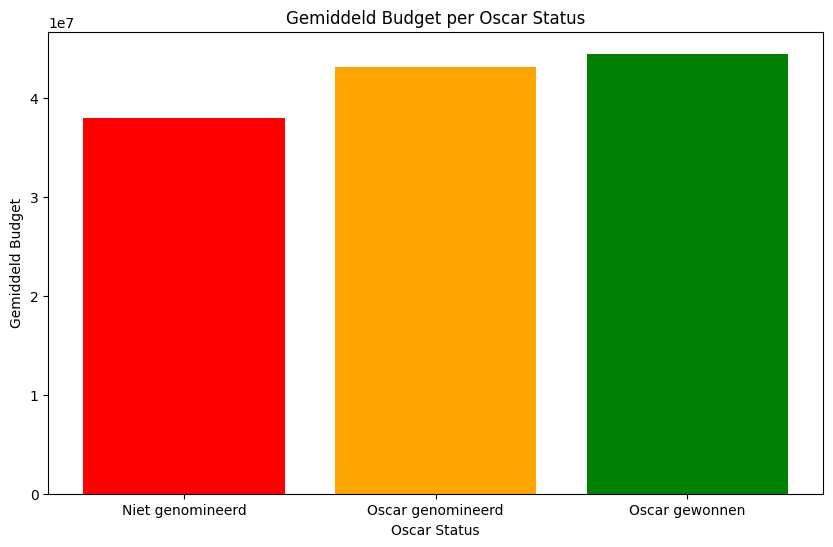

In [49]:
# Analyse van het budget: Kijk naar het gemiddelde budget per Oscar-status
budget_by_status = merged_df.groupby('categorie')['budget'].mean()

# Maak een bar chart voor het gemiddelde budget per Oscar-status
plt.figure(figsize=(10, 6))
plt.bar(budget_by_status.index, budget_by_status, color=['red', 'orange', 'green'])
plt.title('Gemiddeld Budget per Oscar Status')
plt.xlabel('Oscar Status')
plt.ylabel('Gemiddeld Budget')
plt.show()

Hieruit volgt dat de films die oscars hebben gewonnen gemiddeld een hoger budget hadden. Dit kan zeker invloed hebben op de kwaliteit van de film en welke acteurs ingehuurd kunnen worden. Laten we verder kijken in de data

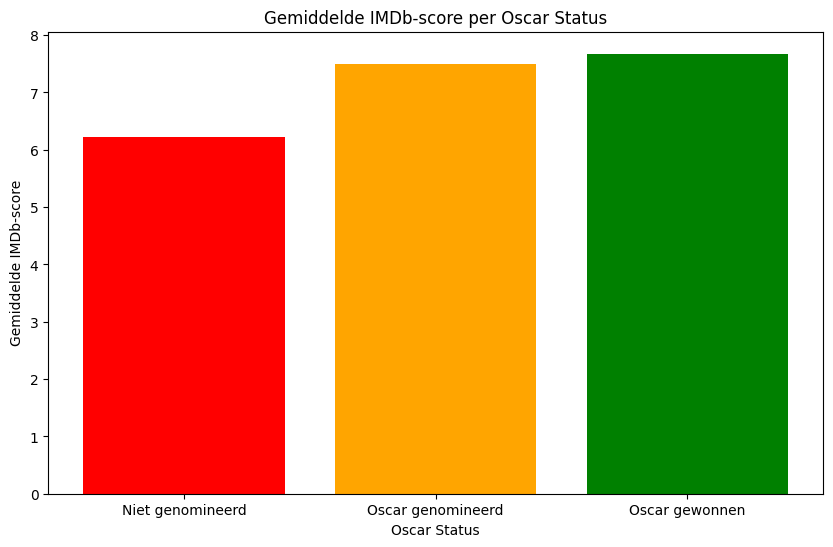

In [50]:
# Analyse van de IMDb-score: Kijk naar de gemiddelde IMDb-score per Oscar-status
imdb_by_status = merged_df.groupby('categorie')['imdb_score'].mean()

# Maak een bar chart voor de gemiddelde IMDb-score per Oscar-status
plt.figure(figsize=(10, 6))
plt.bar(imdb_by_status.index, imdb_by_status, color=['red', 'orange', 'green'])
plt.title('Gemiddelde IMDb-score per Oscar Status')
plt.xlabel('Oscar Status')
plt.ylabel('Gemiddelde IMDb-score')
plt.show()

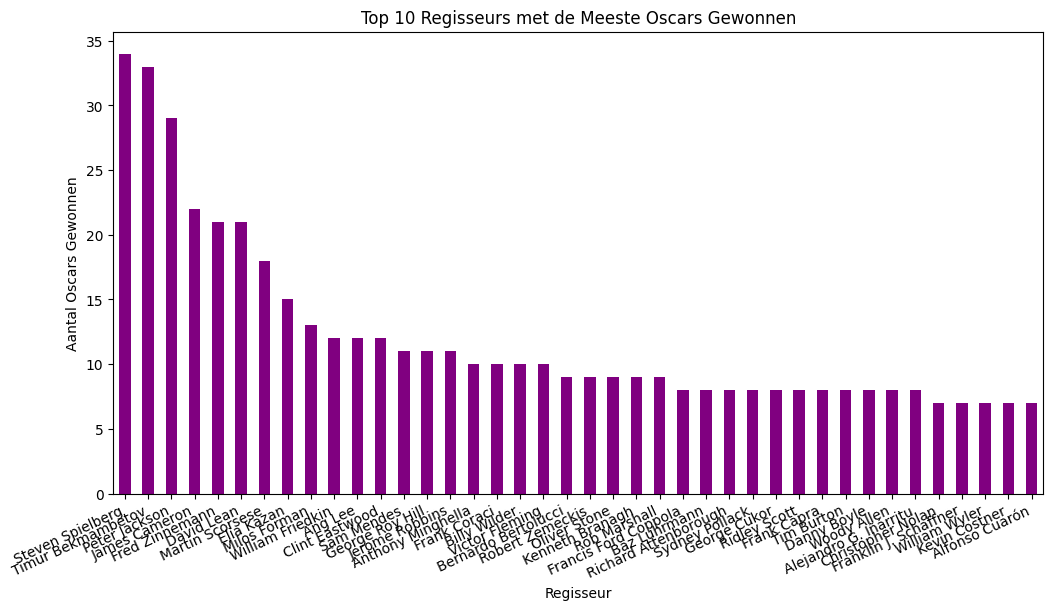

In [51]:
# Analyse van regisseurs: Kijk naar het aantal Oscars gewonnen per regisseur
director_awards = merged_df[merged_df['winner'] == True].groupby('director_name').size().sort_values(ascending=False).head(40)

# Maak een bar chart voor de top 10 regisseurs met de meeste Oscars gewonnen
plt.figure(figsize=(12, 6))
director_awards.plot(kind='bar', color='purple')
plt.title('Top 10 Regisseurs met de Meeste Oscars Gewonnen')
plt.xlabel('Regisseur')
plt.ylabel('Aantal Oscars Gewonnen')
plt.xticks(rotation=25, ha='right')
plt.show()

De regrisseur speelt zeker een rol in het behalen van een oscar. Van de gene die winnen hebben vele rond de 10 oscars gewonnen en we hebben er een paar, zoals Steven spielberg die ver boven het gemiddelde zitten. Wellicht een goede manier om een baseline model van te maken. 

### Correlatie bekijken

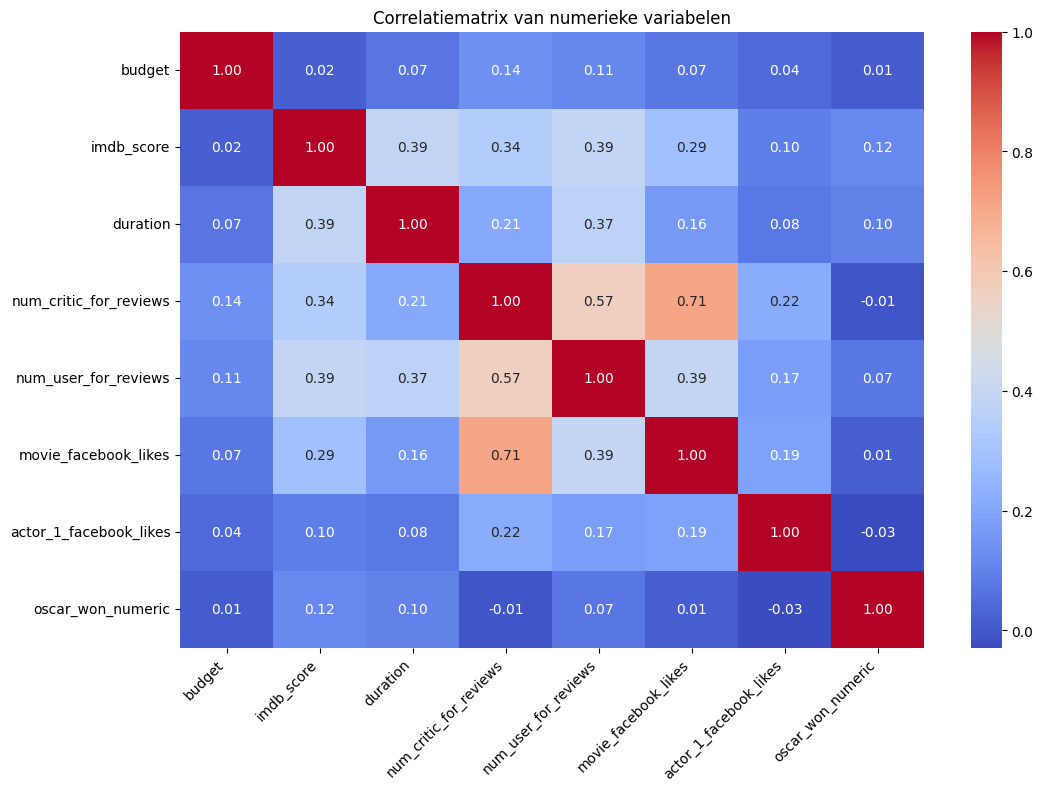

In [52]:
# Analyse van correlaties
merged_df['oscar_won_numeric'] = merged_df['winner'].apply(lambda x: 1 if x == True else (0 if x == False else None))

# Selecteer de feature variables
feat_columns = ['budget', 'imdb_score', 'duration', 'num_critic_for_reviews', 
                   'num_user_for_reviews', 'movie_facebook_likes', 'actor_1_facebook_likes']

# Voeg de 'Oscar gewonnen' kolom toe aan de selectie
correlation_data = merged_df[feat_columns + ['oscar_won_numeric']]

# Bereken de correlatiematrix
correlation_matrix = correlation_data.corr()

# Plot de correlatiematrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlatiematrix van numerieke variabelen')
plt.xticks(rotation=45, ha='right')
plt.show()


Relatief slechte correlaties laten we doorgaan naar het voorspellen.

In [53]:
# Simpele baseline: voorspellen dat geen enkele film een Oscar wint
cleaned_df = merged_df.dropna(subset=['director_name', 'oscar_won_numeric'])
y_test = cleaned_df['oscar_won_numeric'].sample(frac=0.2, random_state=42)
y_baseline_pred = [0] * len(y_test)
baseline_accuracy = accuracy_score(y_test, y_baseline_pred) * 100

print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

Baseline Accuracy: 72.05


### Predicition

In [54]:
# Selecteer de features voor het model
feature_columns = ['budget', 'imdb_score', 'duration', 'num_critic_for_reviews', 
                   'num_user_for_reviews', 'movie_facebook_likes', 'actor_1_facebook_likes']

X_full = cleaned_df[feature_columns].fillna(0)
y_full = cleaned_df['oscar_won_numeric']

# Split de dataset in training en test sets
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

In [55]:
# Model 1: Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_full, y_train_full)
rf_predictions = rf_model.predict(X_test_full)
rf_accuracy = accuracy_score(y_test_full, rf_predictions)
rf_classification_report = classification_report(y_test_full, rf_predictions)

print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print("Random Forest Classification Report:\n", rf_classification_report)


Random Forest Accuracy: 0.70
Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.80      0.80       501
         1.0       0.47      0.44      0.46       194

    accuracy                           0.70       695
   macro avg       0.63      0.62      0.63       695
weighted avg       0.70      0.70      0.70       695



In [56]:
# Model 2: Support Vector Classifier (SVC)
svc_model = SVC(probability=True, random_state=42)
svc_model.fit(X_train_full, y_train_full)
svc_predictions = svc_model.predict(X_test_full)
svc_accuracy = accuracy_score(y_test_full, svc_predictions)
svc_classification_report = classification_report(y_test_full, svc_predictions)

print(f"SVC Accuracy: {svc_accuracy:.2f}")
print("SVC Classification Report:\n", svc_classification_report)

SVC Accuracy: 0.72
SVC Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      1.00      0.84       501
         1.0       0.00      0.00      0.00       194

    accuracy                           0.72       695
   macro avg       0.36      0.50      0.42       695
weighted avg       0.52      0.72      0.60       695



C:\Users\pim-d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pim-d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\pim-d\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

## Conclusie onderzoeksvraag 2

De data is dus niet goed gemerged en zal verder onderzocht moeten worden

## Onderzoeksvraag 3: Hoe kunnen budget en omzet worden gebruikt om logische clusters van de films te vinden?


Om clusters te bepalen in een dataset gaan we nu gebruik maken van unsupervised learning. De algoritmes die we gaan toepassen zijn KMeans en GMM.

We maken een nieuw dataframe aan met 'gross' en 'budget'.

In [57]:
df = dfr[['gross', 'budget']]

In [58]:
df.isna().sum()

gross     884
budget    492
dtype: int64

Alle NaN's verwijderen

In [59]:
df = df.dropna()

In [60]:
df.isna().sum()

gross     0
budget    0
dtype: int64

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3891 entries, 0 to 5042
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gross   3891 non-null   float64
 1   budget  3891 non-null   float64
dtypes: float64(2)
memory usage: 91.2 KB


We gaan kijken of er logische clusters bepaald kunnen worden met unsupervised learning. De kolommen 'gross' en 'budget' worden gebruikt. 

In [62]:
# Code afkomstig van les CM10
# kMeans en GMM maken gebruik van afstandsmaten, daarom is standaardiseren belangrijk
df.reset_index(inplace = True)

# Berekenen van return on investment (ROI).
df['ROI'] = df['gross'] / (df['budget'] + 1)  # +1 want je kan niet delen door 0

# We passen scaling toe zodat de afstandmaten beter zijn verdeeld onder elkaar.
scaler = StandardScaler()
scaler.fit(df[['gross', 'budget', 'ROI']])
df_z = pd.DataFrame(scaler.transform(df[['gross', 'budget', 'ROI']]), columns=['gross_z', 'budget_z', 'ROI_z'])
df[['gross_z', 'budget_z', 'ROI_z']] = df_z

In [63]:
df.head(5)

,index,gross,budget,ROI,gross_z,budget_z,ROI_z
0,0,"760,505,847.00","237,000,000.00",3.21,10.16,0.86,-0.02
1,1,"309,404,152.00","300,000,000.00",1.03,3.70,1.15,-0.04
2,2,"200,074,175.00","245,000,000.00",0.82,2.14,0.90,-0.04
3,3,"448,130,642.00","250,000,000.00",1.79,5.69,0.92,-0.03
4,5,"73,058,679.00","263,700,000.00",0.28,0.32,0.98,-0.05


## Verwijderen van outliers ##

Omdat de modellen gevoelig zijn voor outliers gaan we identificeren welke we gaan verwijderen. Onze onderzoeksvraag vraagt niet om bijzondere gevallen te bepalen, maar om logische clusters te bepalen wat na verwijderen nogsteeds kan worden gedaan. Alle outliers gaan we verwijderen.

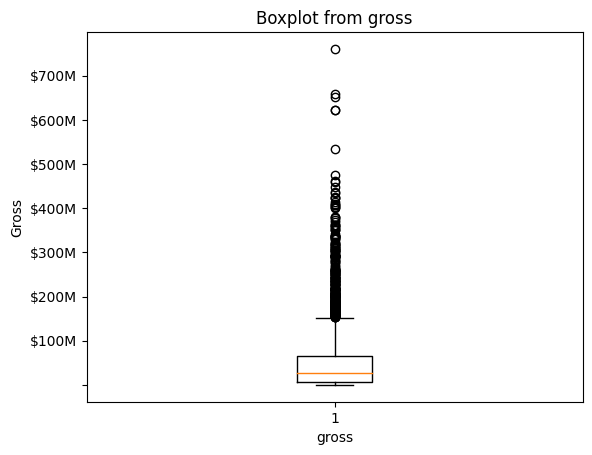

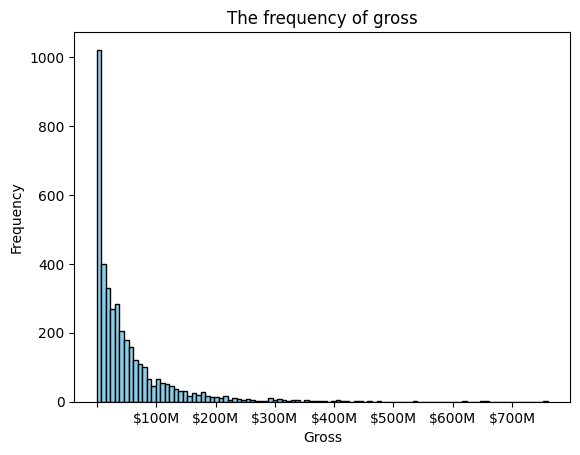

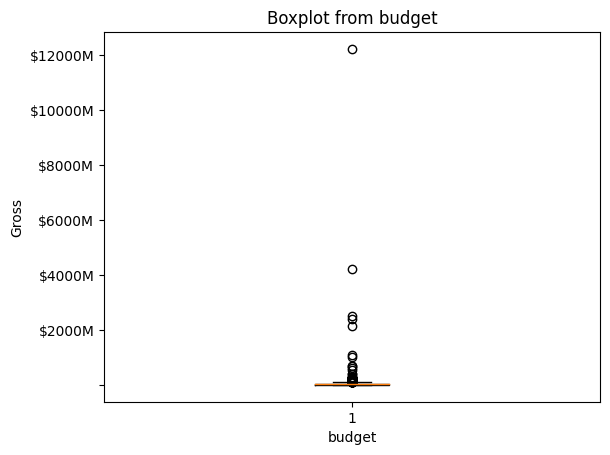

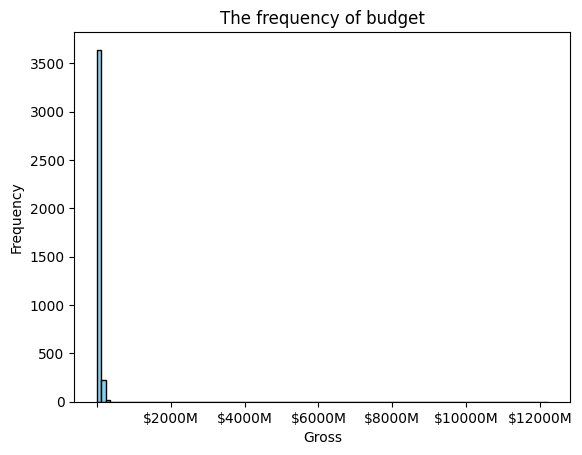

In [64]:
fn.boxplot_gross_and_budget(df, 'gross')
fn.histogram_gross(df, 'gross')

fn.boxplot_gross_and_budget(df, 'budget')
fn.histogram_gross(df, 'budget')

In [65]:
df = fn.remove_outliers(df, 'budget')
df = fn.remove_outliers(df, 'gross')

Opnieuw de boxplots bekijken. We zien dat de outliers zijn verwijderd.

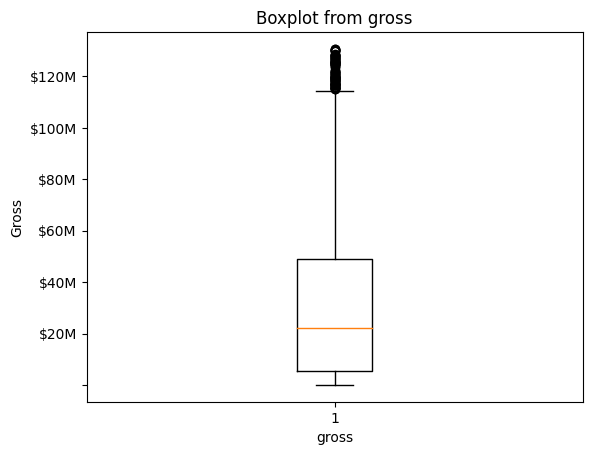

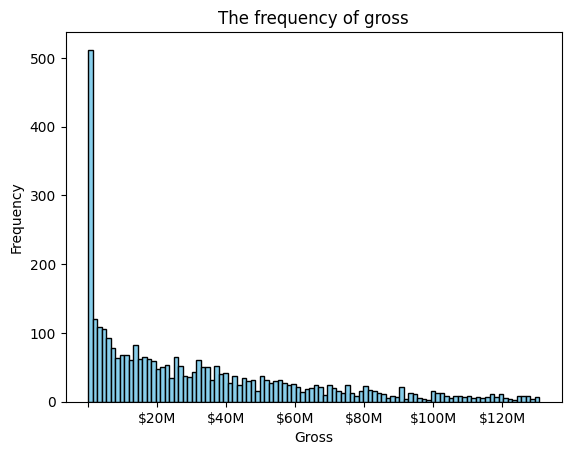

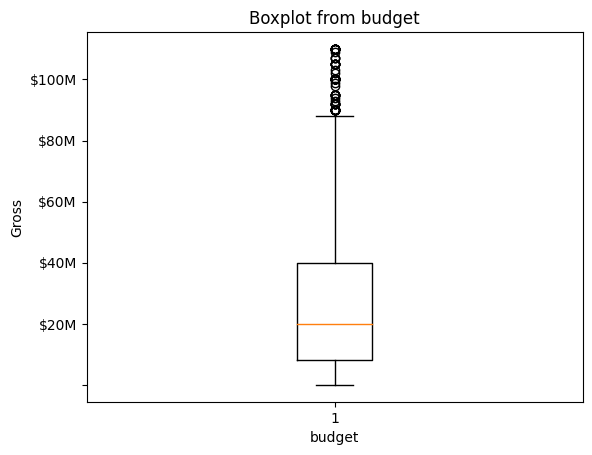

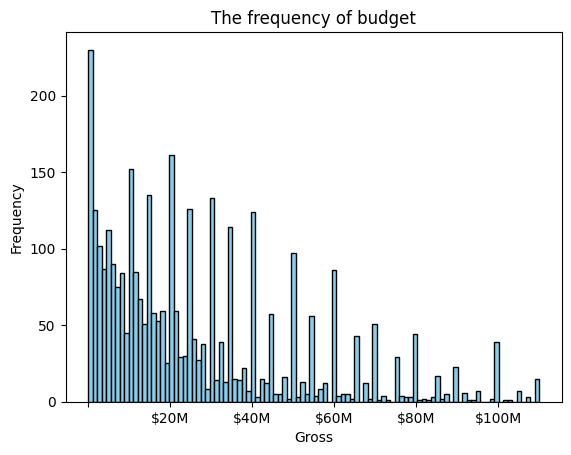

In [66]:
fn.boxplot_gross_and_budget(df, 'gross')
fn.histogram_gross(df, 'gross')

fn.boxplot_gross_and_budget(df, 'budget')
fn.histogram_gross(df, 'budget')

Als we alleen kijken naar de omzet en budget, zien we dat er met het KMeans model geen logische clusters worden gevonden. Het wordt simpelweg opgedeeld in x aantal clusters die oplopen in omzet die dan alle waarden van het budget aan kunnen nemen, niet heel logisch dus.

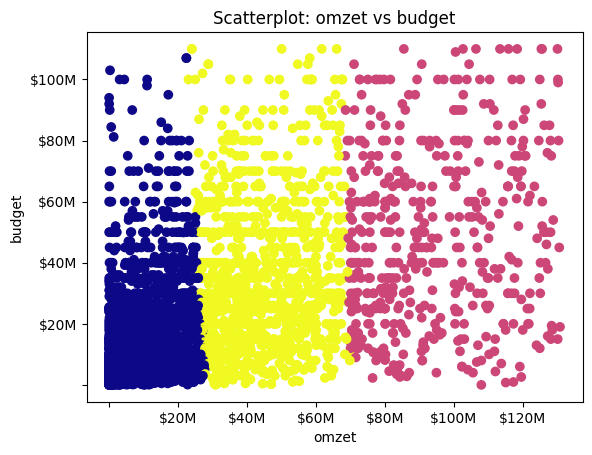

In [67]:
# Maken van een willekeurige clustering
model_kMeans = KMeans(n_clusters=3, random_state=0)
X_kMeans = df[['gross_z', 'budget_z']]

# Clusters 'voorspellen' en opslaan
prediction_kMeans = model_kMeans.fit_predict(X_kMeans)
df['cluster_number'] = model_kMeans.predict(X_kMeans)

# Plotten van 'omzet' en 'budget' en als kleur de clusters
plt.scatter(df['gross'], df['budget'], c=df['cluster_number'], cmap='plasma')
plt.gca().xaxis.set_major_formatter(FuncFormatter(fn.euro_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(fn.euro_formatter))
plt.title('Scatterplot: omzet vs budget')
plt.xlabel('omzet')
plt.ylabel('budget')
plt.show()

Kijken naar de meest logische clustering voor KMeans. De 'knik' zit bij k=3 wat duid op een beste k van 3.

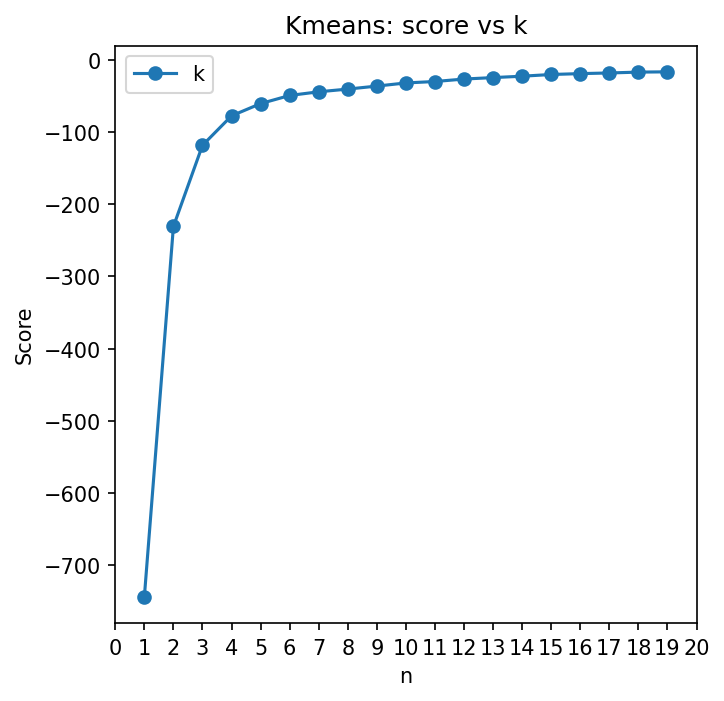

In [68]:
# Code afkomstig van les CM10

data = []

max_k = 20

for i in range(1, max_k):
    model_kMeans = KMeans(n_clusters=i, random_state=0)
    X_kMeans = df[['gross_z', 'budget_z']]

    # Clusters 'voorspellen' en opslaan
    model_kMeans.fit(X_kMeans)

    data.append([i, model_kMeans.score(X_kMeans)])

df_plot_kmeans = pd.DataFrame(data, columns=['k', 'Score'])

fig = plt.figure(figsize=(5,5), dpi=150)

ax = plt.axes()

ax.set(xlim=(0,max_k),
       xlabel='n',
       ylabel='Score',
       title='Kmeans: score vs k')

ax.xaxis.set_major_locator(plt.MaxNLocator(max_k))
ax.ticklabel_format(useOffset=False)
ax.plot(df_plot_kmeans['k'], df_plot_kmeans['Score'], '-o')

ax.legend(['k'])

Nu gaan we hetzelfde doen maar dan met GMM. Ook hier zie je dat het clusters maakt maar deze zijn niet logisch. Er is geen goed onderscheid te maken tussen blockbusters, flops en cultfilms. Films met een hoge omzet en laag budget hebben dezelfde cluster als films met een lage omzet en hoog budget.

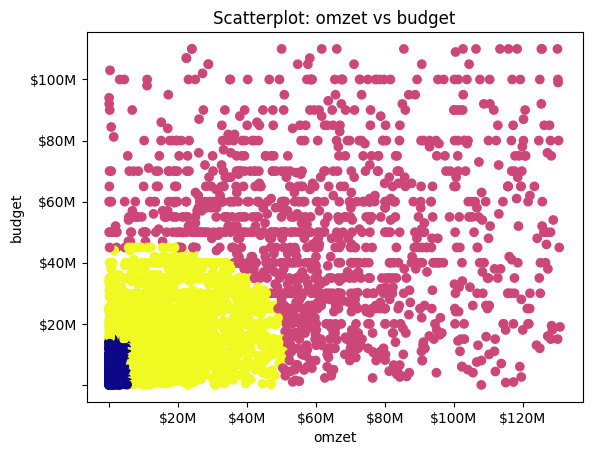

In [69]:
# Maken van een willekeurige clustering
model_gmm = gmm(n_components=3, random_state=0)
X_gmm = df[['gross_z', 'budget_z']]

# Clusters 'voorspellen' en opslaan
prediction_gmm = model_gmm.fit_predict(X_gmm)
df['cluster_number'] = model_gmm.predict(X_gmm)

# Plotten van 'omzet' en 'budget' en als kleur de clusters
plt.scatter(df['gross'], df['budget'], c=df['cluster_number'], cmap='plasma')
plt.gca().xaxis.set_major_formatter(FuncFormatter(fn.euro_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(fn.euro_formatter))
plt.title('Scatterplot: omzet vs budget')
plt.xlabel('omzet')
plt.ylabel('budget')
plt.show()

Kijken naar de meest logische clustering voor GMM. De 'knik' zit bij k=3 wat duid op een beste k van 3. We vinden de grafiek echter een rare vorm hebben waardoor we het model voor GMM niet gaan gebruiken voor onze clustering.

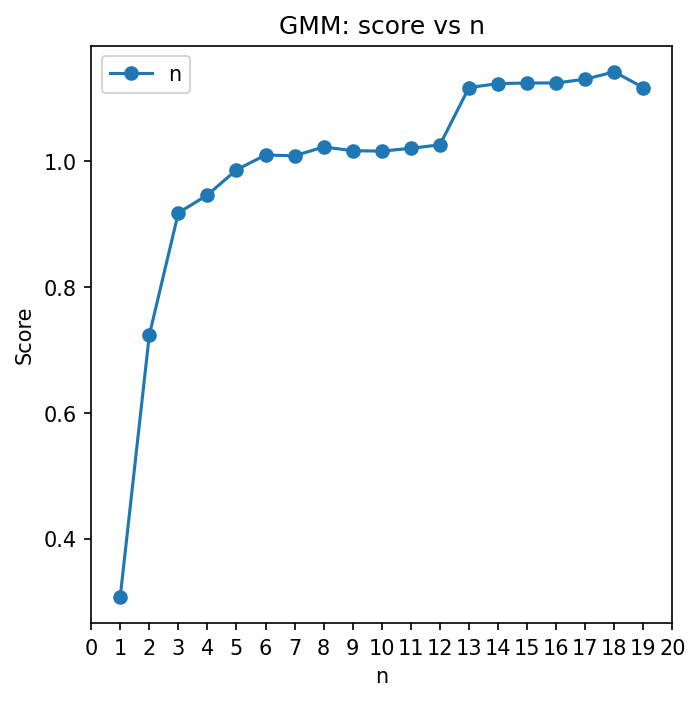

In [70]:
# Code afkomstig van les CM10
data = []

max_n = 20

for i in range(1, max_k):
    model_gmm = gmm(n_components=i, random_state=0)
    X_gmm = df[['gross_z', 'budget_z']]

    prediction_gmm = model_gmm.fit(X_gmm)
    data.append([i, model_gmm.score(X_gmm)])

df_plot_gmm = pd.DataFrame(data, columns=['n', 'Score'])

fig = plt.figure(figsize=(5,5), dpi=150)

ax = plt.axes()

ax.set(xlim=(0,max_n),
       xlabel='n',
       ylabel='Score',
       title='GMM: score vs n')

ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.ticklabel_format(useOffset=False)
ax.plot(df_plot_gmm['n'], df_plot_gmm['Score'], '-o')

ax.legend(['n'])

Misschien moeten we kijken naar de ROI van films. Dit geeft een iets beter beeld bij films die een hoge ROI hebben tov films met een lage ROI. Maar helaas zien we ook hier dat het niet uit maakt. 

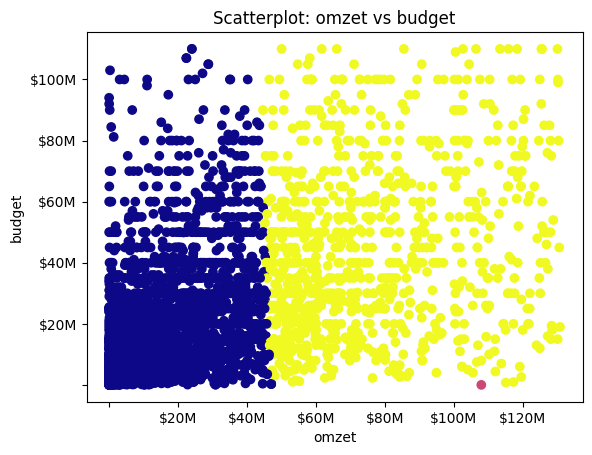

In [71]:
# Maken van een willekeurige clustering
model_kMeans = KMeans(n_clusters=3, random_state=0)
X_kMeans = df[['gross_z', 'budget_z', 'ROI_z']]

# Clusters 'voorspellen' en opslaan
prediction_kMeans = model_kMeans.fit_predict(X_kMeans)
df['cluster_number'] = model_kMeans.predict(X_kMeans)

# Plotten van 'omzet' en 'budget' en als kleur de clusters
plt.scatter(df['gross'], df['budget'], c=df['cluster_number'], cmap='plasma')
plt.gca().xaxis.set_major_formatter(FuncFormatter(fn.euro_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(fn.euro_formatter))
plt.title('Scatterplot: omzet vs budget')
plt.xlabel('omzet')
plt.ylabel('budget')
plt.show()

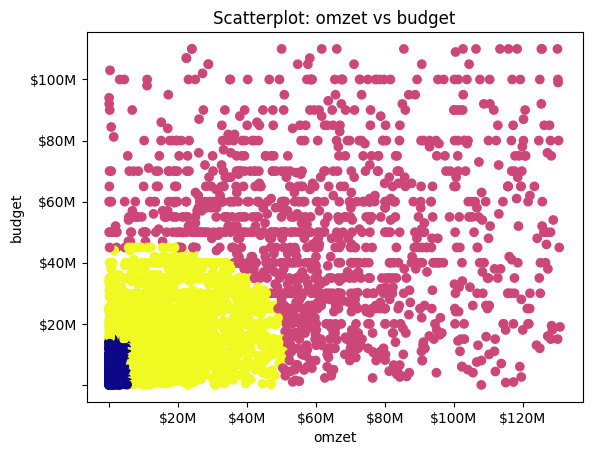

In [72]:
# Maken van een willekeurige clustering
model_gmm = gmm(n_components=3, random_state=0)
X_gmm = df[['gross_z', 'budget_z']]

# Clusters 'voorspellen' en opslaan
prediction_gmm = model_gmm.fit_predict(X_gmm)
df['cluster_number'] = model_gmm.predict(X_gmm)

# Plotten van 'omzet' en 'budget' en als kleur de clusters
plt.scatter(df['gross'], df['budget'], c=df['cluster_number'], cmap='plasma')
plt.gca().xaxis.set_major_formatter(FuncFormatter(fn.euro_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(fn.euro_formatter))
plt.title('Scatterplot: omzet vs budget')
plt.xlabel('omzet')
plt.ylabel('budget')
plt.show()

Natuurlijk zouden we dit zelf wel kunnen maken op basis van een paar regels, namelijk:

Het opdelen van de films in 5 categorieën.

1. Blockbuster: hoog budget met hoge omzet
2. Flop: hoog budget met lage omzet
3. Cultfilm: laag budget met hoge omzet
4. Mid-Range Movie: Gemiddeld budget met gemiddelde omzet
5. Average: Alle andere gevallen

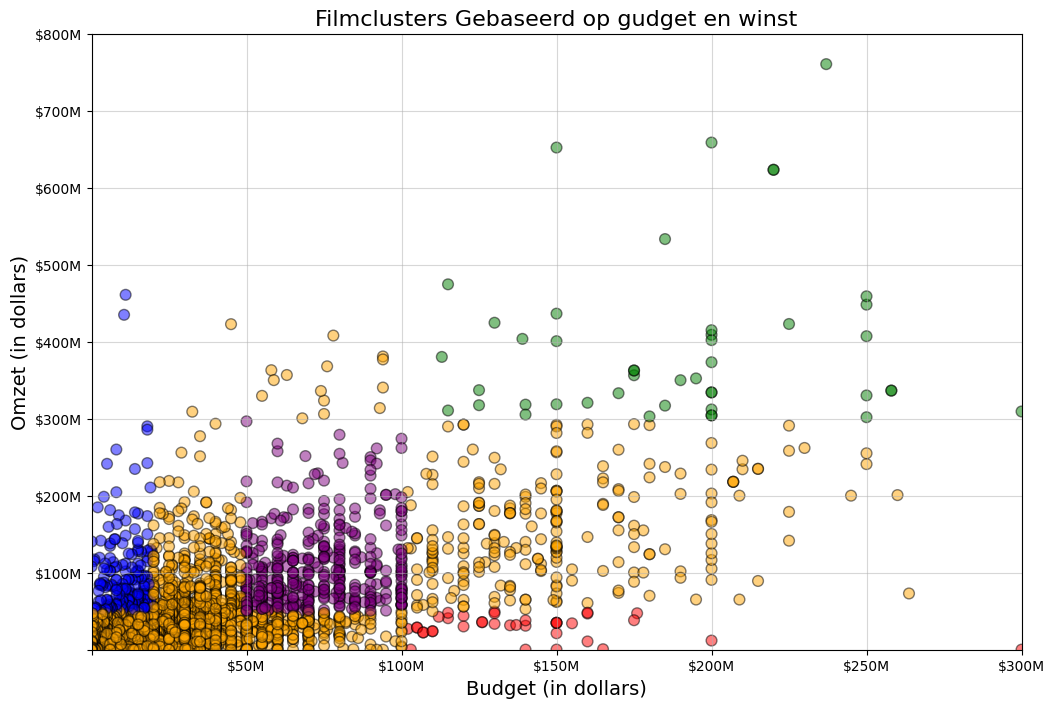

In [73]:
# In volledige dataFrame, alle NaN waarde verwijderen van budget en gross.
df = dfr[['budget', 'gross']].dropna()

# Extreme waarde van budget en gross worden ook verwijderd.
df = df[(df['budget'] < 350000000) & (df['gross'] < 1000000000)] \

# Zie functies.py voor de functie classify_movie
df['Category'] = df.apply(fn.classify_movie, axis=1)

# Scatterplot Visualiseren met kleur
plt.figure(figsize=(12, 8))
colors = {'Blockbuster':'green', 'Flop':'red', 'Cultfilm':'blue', 'Average':'orange', 'Mid-Range Movie':'purple'}
scatter = plt.scatter(df['budget'], df['gross'], 
                      c=df['Category'].map(colors), alpha=0.5, s=60, edgecolor='k', marker='o')

# Titel en labels
plt.title('Filmclusters Gebaseerd op gudget en winst', fontsize=16)
plt.xlabel('Budget (in dollars)', fontsize=14)
plt.ylabel('Omzet (in dollars)', fontsize=14)

# Weergavegrenzen
plt.xlim(0, 300000000)  
plt.ylim(0, 800000000) 

# Grafiek lijn
plt.grid(True, linestyle='-', alpha=0.5)

plt.gca().xaxis.set_major_formatter(FuncFormatter(fn.euro_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(fn.euro_formatter))

plt.show()

**Kleur en kermerken van de clusters in de scatterplot**

- **Groen: blockbuster films**

Deze films zijn met een hoog budget (> 100 miljoen dollar) en met een hoge omzet (>300 miljoen dollar).

We zien groene cluster rechterboven in de grafiek. De succesvolle films.


- **Rood: flop films**

Deze films zijn met een hoog budget (> 100 miljoen dollar) en met een lage omzet (<50 miljoen dollar).

We zien rode cluster rechtsonder in de grafiek. Deze is een klein cluster.


- **Blauw: cultfilms**

Deze films zijn met een laag budget (<20 miljoen dollar) en met een relatief hoge omzet (>50 miljoen dollar).

We zien blauwe cluster linkerboven in de grafiek. Dit cluster laten zien de films met een laag budget toch tot een groot succes kan zijn.


- **Paars: mid range films**

Deze films zijn met een middelgroot budget (50-100 miljoen dollar) en met een middelgroot omzet (50-300 miljoen dollar).

We zien paarse cluster midden in de grafiek. Deze is een groot cluster, betekent er zijn heel veel prima films.


- **Orange: rest van de films**

Alle film die niet in bovenstaande categorieën.

We zien orange cluster verspreid over de grafiek. Er zijn heel veel films die gewoon middelmatige resultaten halen, dus niet te ondersheiden in budget of omzet.



## Conclusie onderzoeksvraag 3


Door middel van unsupervised learning kan er geen logische clusters gemaakt worden. Niet om basis van de omzet en budget maar ook niet van de ROI van deze 2. De modellen vinden wel andere clusters, maar deze zijn niet logisch. Er is geen goed onderscheid te maken tussen blockbusters, flops en cultfilms als je kijkt naar de kleuren van de clusters. Zelfs met verschillende k waarden van beide modellen wordt het er niet beter op. Films met een hoge omzet en laag budget hebben dezelfde cluster als films met een lage omzet en hoog budget.

We kunnen wel door middel van rule based tabellen een logische cluster maken. Maar goed, dat is supervised en niet unsupervised learning.

Het is dus mogelijk om logische clusters te vinden met een supervised techniek, maar niet met onze huidige unsupervised technieken.